In [1]:
## Import Libraries

import astropy as astro
import astropy.units as u
import astropy.wcs as wcs
import gausspy as gp
import gausspy.gp
import gausspyplus as gpp
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random as rand
import scipy as sci
import scipy.optimize
import sympy as sp

import csv
import dis
import inspect
import os
import sys

from astropy import units as u
from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.io import misc
from astropy.table import QTable, Table, Column
from astropy.visualization import astropy_mpl_style
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch

from datetime import datetime

from gausspyplus.prepare import GaussPyPrepare
from gausspyplus.decompose import GaussPyDecompose

from IPython.display import display_html

from matplotlib.pyplot import cm

from numpy import format_float_scientific as sci

from photutils import detect_sources
from photutils import source_properties
from photutils import EllipticalAperture

from scipy.optimize import *
from scipy.integrate import quad
from scipy import spatial


#plt.style.use(astropy_mpl_style)
%matplotlib inline
#mpl.use("pgf")
# plt.rcParams.update({
#     "font.family": "serif",  # use serif/main font for text elements
#     "text.usetex": True,     # use inline math for ticks
#     "pgf.rcfonts": False,    # don't setup fonts from rc parameters
#     "pgf.preamble": [
#          "\\usepackage{units}",          # load additional packages
#          "\\usepackage{metalogo}",
#          "\\usepackage{unicode-math}",   # unicode math setup
#          r"\setmathfont{xits-math.otf}",
#          r"\setmainfont{DejaVu Serif}",  # serif font via preamble
#          ]
# })

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

In [2]:
def createFolder(directory): ##https://gist.github.com/keithweaver/562d3caa8650eefe7f84fa074e9ca949
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)


def unravel(list):
    return np.array([i for array in list for i in array])

## Part One

In [3]:

# The columns in this table are: (these aren't the actual column names)

# (1) galaxy name
# (2) ratio of Hbeta flux to Halpha flux
# (3) note on Hbeta flux ratio
# (4) ratio of [OIII] 5007 flux to Halpha flux
# (5) note on [OIII] flux ratio
# (6) ratio of [OI] 6300 flux to Halpha flux
# (7) note on [OI] flux ratio
# (8) ratio of [NII] 6583 flux to Halpha flux
# (9) note on [NII] flux ratio
# (10) log of (the observed Halpha flux in units of erg/cm^2/s)
# (11) note on the log of the observed Halpha flux
# (12) log of (the Halpha luminosity in units of erg/s)
# (13) note on the log of the Halpha luminosity
# (14) equivalent width of the Halpha line (units of Angstroms)
# (15) note on the Halpha equivalent width
# (16) FWHM of the [NII] 6583 line (units of km/s)
# (17) note on the [NII] line width

# The notes mean:

#  L = 3 sigma lower limit
#  u = 3 sigma upper limit
#  s = line strength obtained by scaling the intensity of another line
#  b = value with substantial uncertainty of +/- 30-50%
#  c = value with very substantial uncertainty of +/- 100%

galaxOg = pd.read_csv("./dataTable1.csv",sep=',')
#df['[NII]6583 FWHM note']
#df.where(df.notnull(), None,inplace=True)
#galaxOG['[NII]6583 FWHM note'].fillna('', inplace=True)
galaxOg.replace(r'^\s*$', np.nan, regex=True,inplace=True)
galaxOg.replace(['u ', 'c ', 'b ', 's '], ['u', 'c', 'b', 's'],inplace=True)
galaxOg.shape

(418, 17)

In [4]:
galaxOgFilt = galaxOg.query(" `Hbeta` == `Hbeta` ")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007` == `[OIII]5007` ")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583` == `[NII]6583` ")
c = str('c')
b = str('b')
sb = str('sb')
galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @c ")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @c ")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @c ")

galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @b")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @b")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @b")

galaxOgFilt = galaxOgFilt.query(" `Hbeta note` != @sb")
galaxOgFilt = galaxOgFilt.query(" `[OIII]5007 note` != @sb")
galaxOgFilt = galaxOgFilt.query(" `[NII]6583 note` != @sb")
#galaxOgFilt = galaxOgFilt.reset_index()
galaxOgFilt.shape

(294, 17)

In [5]:
#subtest = test[test['Hbeta note'] == 'u ']
#galaxOgFilt.replace(['u ', 'c ', 'b ', 's '], ['u', 'c', 'b', 's'],inplace=True)
#display(subtest)
#galaxOgFilt['Hbeta note'].unique()

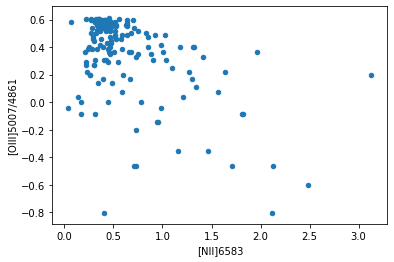

In [6]:
galaxOgFilt['[OIII]5007 ratio'] = galaxOgFilt['[OIII]5007'].astype(np.float) / galaxOgFilt['Hbeta'].astype(np.float)

galaxOgFilt['[NII]6583 ratio'] = galaxOgFilt['[NII]6583'].astype(np.float) / galaxOgFilt['Hbeta'].astype(np.float)
galaxOgFilt['[OIII]5007/4861'] = np.log10(4.2 - 9.4*galaxOgFilt['[OIII]5007'].astype(np.float))
galaxOgFilt.plot(kind='scatter', x = '[NII]6583', y = '[OIII]5007/4861')

#plt.show()

## Part Two

In [7]:
fileIndex = [1,2,3,4,5,6,7,8,9,10]
emGal = [pd.read_csv('./spectrum'+str(i)+'.txt', sep = '    ',
                     header=None, names=["Rest Wavelength","Flux"],
                     engine = "python") for i in fileIndex]
absGal = [pd.read_csv('./partner'+str(i)+'.txt', sep = '    ',
                     header=None, names=["Rest Wavelength","Flux"],
                     engine = "python") for i in fileIndex]

distMpc = [71.1, 75.1, 22.0, 18.2, 40.9, 24.6, 16.6, 14.6, 32.8, 16.2]
plotExt = str('.png')

In [8]:
def galPair(pairNum=0): ## Just takes an int from 1-10 and returns emmission and absorption DataFrames
    ind = pairNum - 1
    if ind < 0:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        ind = 0
    gal, part = emGal[ind], absGal[ind]
    return gal, part

def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)

#### Step One

In [9]:
def trim(pairNum=0, verbose=False, plot=False, savePlot='none'): ## Trims DataFrames so galaxy pairs have matching range
    
    if pairNum <= 0 or pairNum > 10:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        pair = 1
        pairStr = str(0)+str(pair)
    elif pairNum != 10:
        pair = pairNum
        pairStr = str(0)+str(pair)
    elif pairNum == 10:
        pair = pairNum
        pairStr = str(pair)
    gal, part = galPair(pair)
    #galMax = gal['Rest Wavelength'].max()
    #partMax = part['Rest Wavelength'].max()
    if gal['Rest Wavelength'].max() <= part['Rest Wavelength'].max():
        plusle = gal['Rest Wavelength'].max() ## Max value of spectra emmission lines
        partFilt = part.query('`Rest Wavelength` <= @plusle')
        galFilt = gal.query('`Rest Wavelength` <= @plusle')
        #print('gal.max<part.max')
    elif gal['Rest Wavelength'].max() >= part['Rest Wavelength'].max(): 
        plusle = part['Rest Wavelength'].max() ## Max value of absorption lines
        galFilt = gal.query('`Rest Wavelength` <= @plusle')
        partFilt = part.query('`Rest Wavelength` <= @plusle')
        #print('gal.max>part.max')
    
    #galMin = gal['Rest Wavelength'].min()
    #partMin = part['Rest Wavelength'].min()   
    if gal['Rest Wavelength'].min() >= part['Rest Wavelength'].min():
        minun = gal['Rest Wavelength'].min() ## Min Value of emmission lines
        partFilt = partFilt.query('`Rest Wavelength` >= @minun')
        galFilt = galFilt.query('`Rest Wavelength` >= @minun')
        #print('gal.min>part.min')
    elif gal['Rest Wavelength'].min() <= part['Rest Wavelength'].min():
        minun = part['Rest Wavelength'].min() ## Min Value of partner absorption lines
        galFilt = galFilt.query('`Rest Wavelength` >= @minun')
        partFilt = partFilt.query('`Rest Wavelength` >= @minun')
        #print('gal.min<part.min')
    
    if verbose:
        galCut = np.abs(gal.shape[0] - galFilt.shape[0])
        partCut = np.abs(part.shape[0] - partFilt.shape[0])
        galCent = 100*( galCut / gal.shape[0] )
        galCent = np.around(galCent,2)
        partCent = 100*(partCut /part.shape[0])
        partCent = np.around(partCent,2)
        
        print("galaxy pair "+pairStr)
        print("minimum wavelength: ",minun," Angstroms")
        print("maximum wavelength",plusle," Angstroms")
        #print("number of points removed from emission line: ",galCut)
        #print("number of points removed from absorption line: ",partCut)
        print("percent of emission line data points removed: ", galCent,"%")
        print("percent of absorption line data points removed: ", partCent,"%")
        print("number of emission line data points after cut: ",galFilt.shape[0])
        print("number of absorption line data points after cut:",partFilt.shape[0])
        print()
        
    if plot:
        tit = str("Flux vs. Rest Wavelength \n for Galaxy Pair "+pairStr)
        axTrim = galFilt.plot(
            x ='Rest Wavelength',y='Flux', 
            color='orange', label='Emission Line\n Galaxies')
        partFilt.plot(
            x ='Rest Wavelength',y='Flux',
            color='blue', label='Absorption Line\n Galaxies',
            title=tit, ax =axTrim)
        axTrim.set(xlabel=r'Wavelength ($\AA$)', ylabel=r'Flux ($\frac{ergs}{s \cdot cm^{2}}$)')
        if savePlot != 'none':
            directory = './galaxyPairPlots/trimmedPlots/'
            createFolder(directory)
            
            
            if savePlot == 'trim':
                #print('saving trimmed wavelength plot...')
                mpl.pyplot.savefig(directory+'trimWavelength'+pairStr+plotExt,bbox_inches='tight')
                print('saved '+directory+'trimWavelength'+pairStr+plotExt)
                #print('trimmed plot saved')
                plt.show()
            elif savePlot == 'both':
                #print('saving trimmed wavelength plot...')
                mpl.pyplot.savefig(directory+'trimWavelength'+pairStr+plotExt,bbox_inches='tight')
                print('saved '+directory+'trimWavelength'+pairStr+plotExt)
                directory = './galaxyPairPlots/trimmedPlots/untrimmed/'
                createFolder(directory)
                #print('trimmed plot saved')
                plt.show()
                plt.clf()
                #print('saving full wavelength plot...')
                axUntrim = gal.plot(
                    x ='Rest Wavelength',y='Flux', 
                    color='purple', label='Emission Line\n Galaxies')
                part.plot(
                    x ='Rest Wavelength',y='Flux',
                    color='pink', label='Absorption Line\n Galaxies',
                    title=tit+' (Untrimmed)', ax =axUntrim)
                axUntrim.set(xlabel=r'Wavelength ($\AA$)', 
                             ylabel=r'Flux ($\frac{ergs}{s \cdot cm^{2}}$)')
                plt.axvline(x=plusle,color='black',linestyle='dashed')
                plt.axvline(x=minun,color='black',linestyle='dashed')
                mpl.pyplot.savefig(directory+'fullWavelength'+pairStr+plotExt,bbox_inches='tight')
                print('saved '+directory+'fullWavelength'+pairStr+plotExt)
                plt.show()
            else:
                print(str(savePlot)+' is not a valid argument!')
                print('arguments for savePlot (strings): none, trim, both')
        elif savePlot == 'none':
            plt.show()
    if plot is False and savePlot != 'none':
        print('WARNING: Plot will not be saved without adding the argument `plot=True`')
    return galFilt, partFilt


saved ./galaxyPairPlots/trimmedPlots/trimWavelength01.png


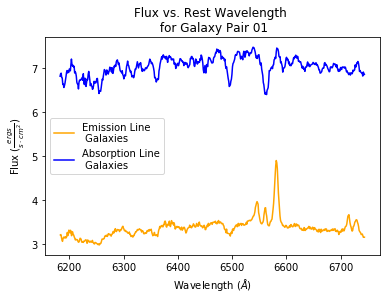

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength01.png


<Figure size 432x288 with 0 Axes>

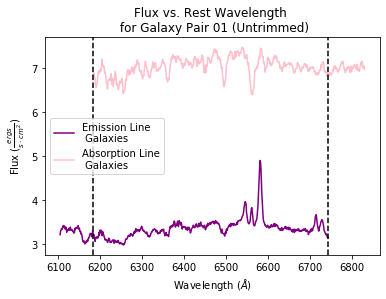

saved ./galaxyPairPlots/trimmedPlots/trimWavelength02.png


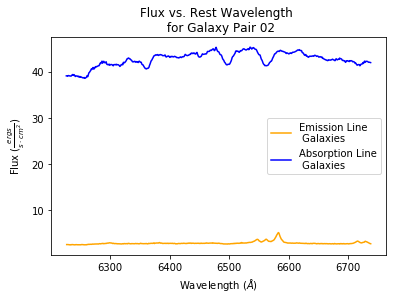

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength02.png


<Figure size 432x288 with 0 Axes>

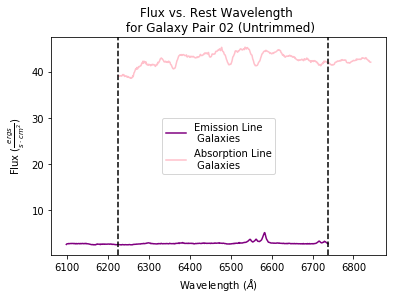

saved ./galaxyPairPlots/trimmedPlots/trimWavelength03.png


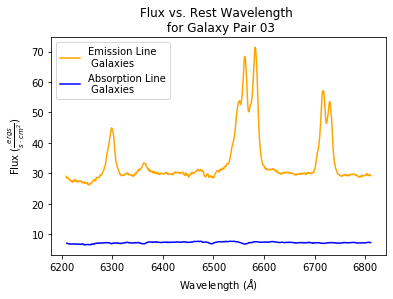

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength03.png


<Figure size 432x288 with 0 Axes>

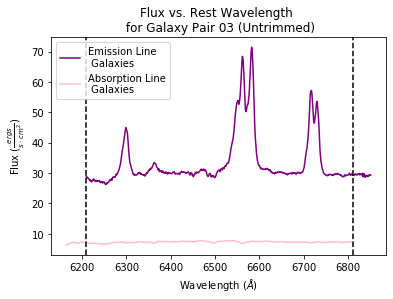

saved ./galaxyPairPlots/trimmedPlots/trimWavelength04.png


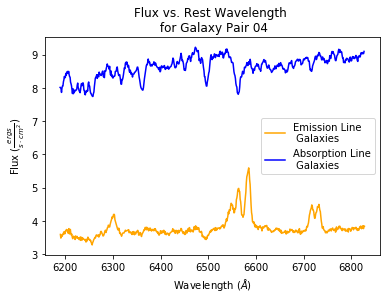

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength04.png


<Figure size 432x288 with 0 Axes>

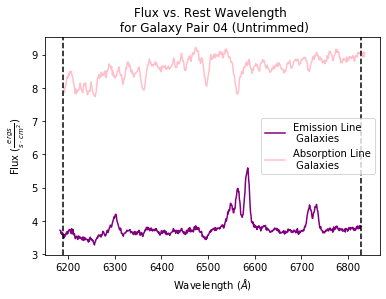

saved ./galaxyPairPlots/trimmedPlots/trimWavelength05.png


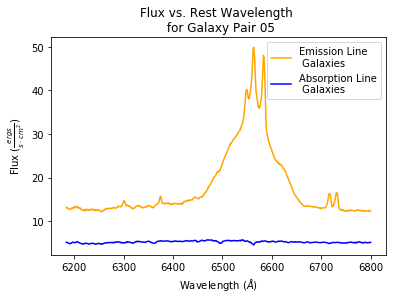

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength05.png


<Figure size 432x288 with 0 Axes>

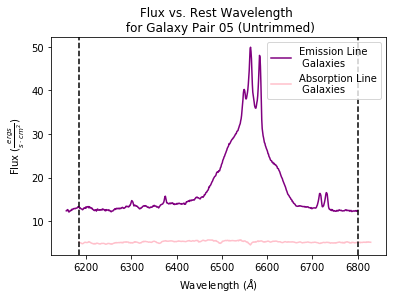

saved ./galaxyPairPlots/trimmedPlots/trimWavelength06.png


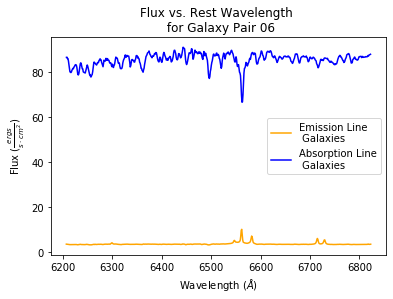

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength06.png


<Figure size 432x288 with 0 Axes>

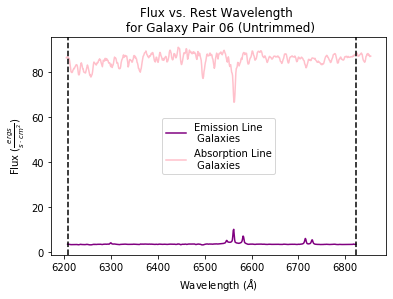

saved ./galaxyPairPlots/trimmedPlots/trimWavelength07.png


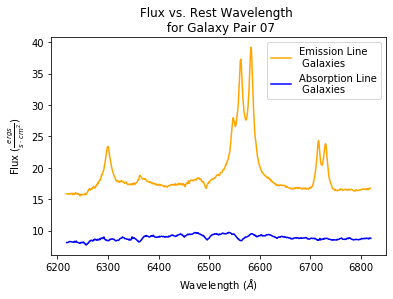

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength07.png


<Figure size 432x288 with 0 Axes>

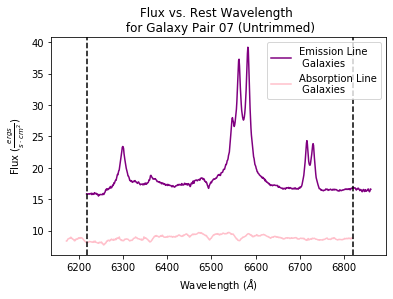

saved ./galaxyPairPlots/trimmedPlots/trimWavelength08.png


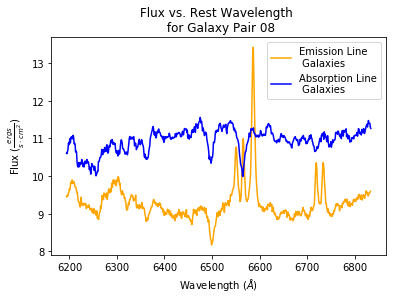

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength08.png


<Figure size 432x288 with 0 Axes>

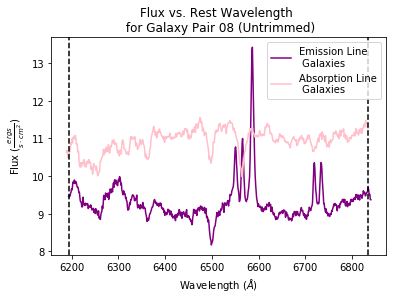

saved ./galaxyPairPlots/trimmedPlots/trimWavelength09.png


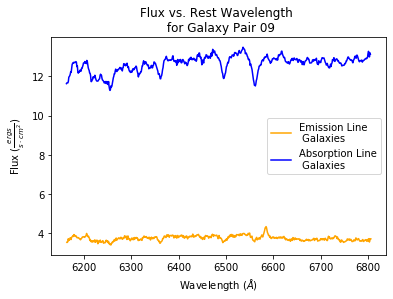

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength09.png


<Figure size 432x288 with 0 Axes>

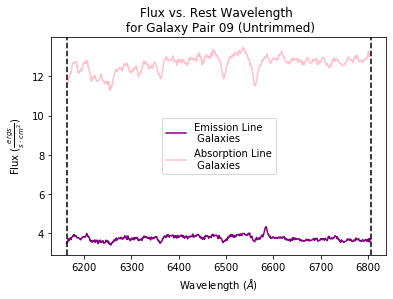

saved ./galaxyPairPlots/trimmedPlots/trimWavelength10.png


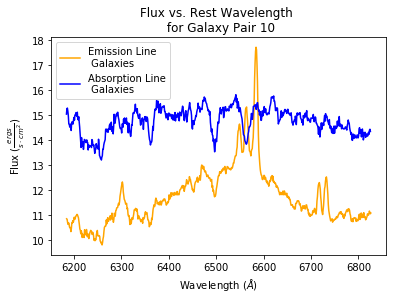

saved ./galaxyPairPlots/trimmedPlots/untrimmed/fullWavelength10.png


<Figure size 432x288 with 0 Axes>

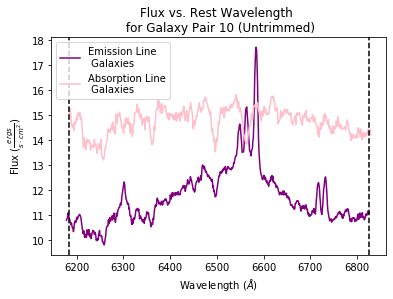

In [10]:
tempTrim = [trim(pairNum=p,plot=True,savePlot='both') for p in fileIndex]

In [11]:
def interpolate(pairNum=0, verbose=False, plot=False, savePlot=False): ## Interpolates pair to 
    ## matching index
    if pairNum <= 0 or pairNum > 10:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        pair = 1
        pairStr = str(0)+str(pair)
    elif pairNum != 10:
        pair = pairNum
        pairStr = str(0)+str(pair)
    elif pairNum == 10:
        pair = pairNum
        pairStr = str(pair)
    
    gal, part = trim(pairNum=pair)
    galRe = gal.set_index('Rest Wavelength')
    partRe = part.set_index('Rest Wavelength')
    galLength = round(len(galRe.index))
    partLength = round(len(partRe.index))
    if galLength >= partLength:
        minun = round(partRe.index.min())
        plusle = round(partRe.index.max())
    elif galLength <= partLength:
        minun = round(galRe.index.min())
        plusle = round(galRe.index.max())
    
    numPoints = round(abs(plusle-minun))
    newIndex = np.linspace(minun,plusle-1,numPoints) ## need to subtract one from max to keep range correct
    
    galInt = pd.DataFrame(index=newIndex)
    galInt.index.name = galRe.index.name
    
    partInt = pd.DataFrame(index=newIndex)
    partInt.index.name = partRe.index.name
    
    for colname, col in galRe.iteritems():
        galInt[colname] = np.interp(newIndex,galRe.index,col)
    for colname, col in partRe.iteritems():
        partInt[colname] = np.interp(newIndex,partRe.index,col)
    galInt.reset_index(inplace=True)
    partInt.reset_index(inplace=True)
    
    if verbose:
        numPointsDiff = abs(galLength - partLength)
        print("galaxy pair "+pairStr)
        print("minimum wavelength: ",minun," Angstroms")
        print("maximum wavelength",plusle," Angstroms")
        if galLength >= partLength:
            print('emission line galaxy has ',numPointsDiff,' more data points than the partner absorption line galaxy')
        elif galLength <= partLength:
            print('emission line galaxy has ',numPointsDiff,' fewer data points than the partner absorption line galaxy')
    
    if plot:
        tit = str('Effects of interpolation for Galaxy Pair '+str(pairStr))
        axGal = gal.plot(
            x ='Rest Wavelength',y='Flux', 
            color='purple', label='Original Emission Lines', 
            title=tit, lw=4)
        galInt.plot(
            x ='Rest Wavelength',y='Flux',
            color='orange', label='Interpolated Emission Lines',
            ax =axGal)
        part.plot(
            x ='Rest Wavelength',y='Flux',
            color='pink', label='Original Absorption Lines', 
            lw=4, ax =axGal)
        partInt.plot(
            x ='Rest Wavelength',y='Flux',
            color='blue', label='Interpolated Absorption Lines', 
            ax =axGal)
        axGal.set(xlabel=r'Wavelength ($\AA$)', 
                  ylabel=r'Flux ($\frac{ergs}{s \cdot cm^{2}}$)')
        if savePlot:
            directory = './galaxyPairPlots/interpolation/'
            createFolder(directory)
            mpl.pyplot.savefig(directory+'interpWavelengths'+pairStr+plotExt,bbox_inches='tight')
            print('saved '+directory+'interpWavelengths'+pairStr+plotExt)
        plt.show()
    if plot is False and savePlot:
        print('WARNING: Plot will not be saved without the argument `plot=True`')
    
    return galInt, partInt

saved ./galaxyPairPlots/interpolation/interpWavelengths01.png


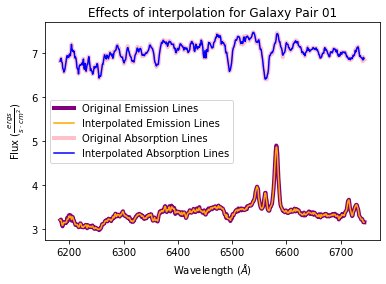

saved ./galaxyPairPlots/interpolation/interpWavelengths02.png


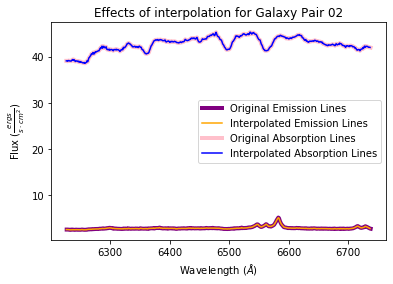

saved ./galaxyPairPlots/interpolation/interpWavelengths03.png


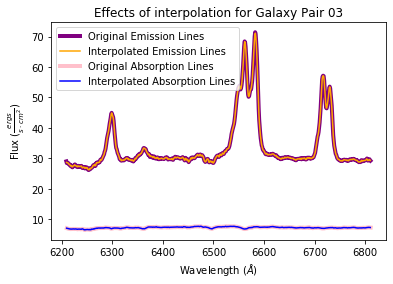

saved ./galaxyPairPlots/interpolation/interpWavelengths04.png


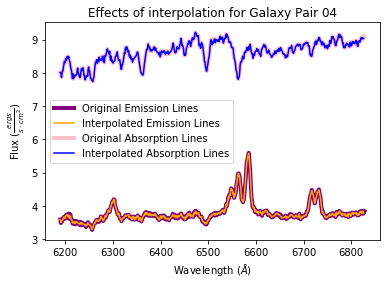

saved ./galaxyPairPlots/interpolation/interpWavelengths05.png


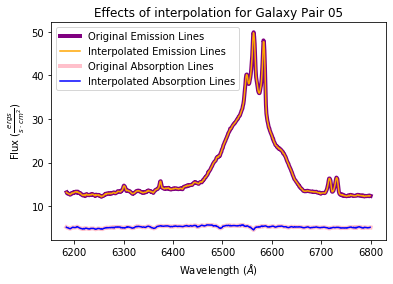

saved ./galaxyPairPlots/interpolation/interpWavelengths06.png


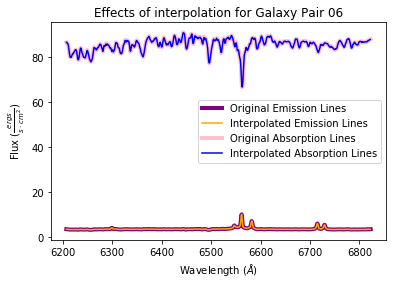

saved ./galaxyPairPlots/interpolation/interpWavelengths07.png


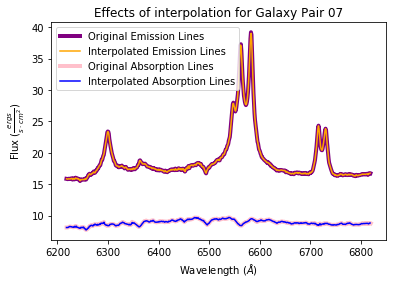

saved ./galaxyPairPlots/interpolation/interpWavelengths08.png


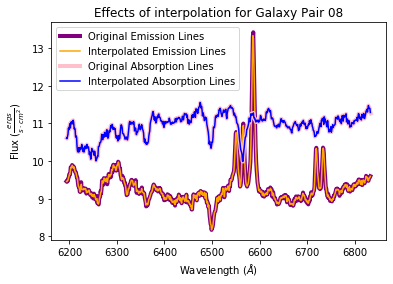

saved ./galaxyPairPlots/interpolation/interpWavelengths09.png


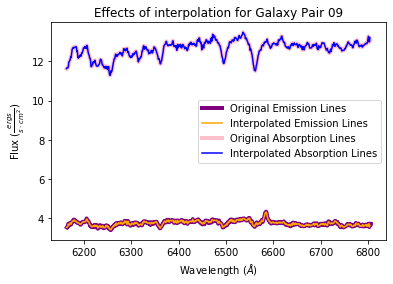

saved ./galaxyPairPlots/interpolation/interpWavelengths10.png


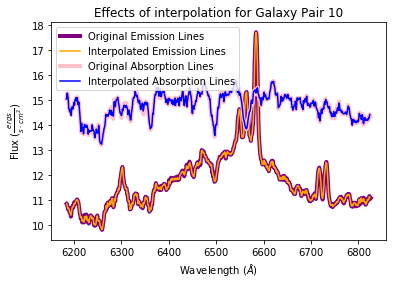

In [12]:
saveInt = [interpolate(pairNum=p,plot=True,savePlot=True) for p in fileIndex]

In [13]:
def scaleSub(pairNum=0, verbose=False,plot=False,savePlot=False,table=False,method='rls'):
    if pairNum <= 0 or pairNum > 10:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        pair = 1
        pairStr = str(0)+str(pair)
    elif pairNum != 10:
        pair = pairNum
        pairStr = str(0)+str(pair)
    elif pairNum == 10:
        pair = pairNum
        pairStr = str(pair)
    gal, part = interpolate(pair)
    rat = abs(gal/part)
    optFunc = lambda x: gal['Flux'] - x*part['Flux']
    
    ls = least_squares(optFunc, rat['Flux'].median())
    ls_scale = float(ls.x)
    ls_soft = least_squares(optFunc, rat['Flux'].median(),loss='soft_l1',f_scale=0.1)
    ls_soft_scale =  float(ls_soft.x)
    
    ls_part_scale = pd.DataFrame(index=part.index)
    ls_part_scale['Rest Wavelength'] = part['Rest Wavelength']
    ls_part_scale['Flux'] = ls_scale*part['Flux']
    ls_spec = pd.DataFrame(index=gal.index)
    ls_spec['Rest Wavelength'] = gal['Rest Wavelength']
    ls_spec['Flux'] = gal['Flux'] - ls_part_scale['Flux']
    
    ls_soft_part_scale = pd.DataFrame(index=part.index)
    ls_soft_part_scale['Rest Wavelength'] = part['Rest Wavelength']
    ls_soft_part_scale['Flux'] = ls_soft_scale*part['Flux']
    ls_soft_spec = pd.DataFrame(index=gal.index)
    ls_soft_spec['Rest Wavelength'] = gal['Rest Wavelength']
    ls_soft_spec['Flux'] = gal['Flux'] - ls_soft_part_scale['Flux']
    
    scaleDiff  = abs(ls_scale-ls_soft_scale)
    ls_avg = round(ls_spec['Flux'].mean(),5)
    ls_std = round(ls_spec['Flux'].std(),5)
    ls_med = round(ls_spec['Flux'].median(),5)
    ls_soft_avg = round(ls_soft_spec['Flux'].mean(),5)
    ls_soft_std = round(ls_soft_spec['Flux'].std(),5)
    ls_soft_med = round(ls_soft_spec['Flux'].median(),5)
    avgDiff = round(abs(ls_avg-ls_soft_avg),5)
    stdDiff = round(abs(ls_std-ls_soft_std),5)
    #avgDiffPower = math.floor(math.log10(avgDiff))
    medDiff = round(abs(ls_med-ls_soft_med),5)
    #medDiffPower = math.floor(math.log10(medDiff))
    
    if table:
        tabDat = {'Galaxy Pair': [pair],
                  'Wavelength Min': [gal['Rest Wavelength'].min()],
                  'Wavelength Max': [gal['Rest Wavelength'].max()],
                  'Mean Emission Flux': [gal['Flux'].mean()],
                  'Mean Absorption Flux': [part['Flux'].mean()],
                  'Least Square Scale Factor': [round(ls_scale,5)],
                  'Robust Least Square Scale Factor': [round(ls_soft_scale,5)],
                  'Least Square Mean Star-Free Emission Line Flux': [ls_avg],
                  'Robust Least Square Mean Star-Free Emission Line Flux': [ls_soft_avg],
                  'Least Square Star-Free Emission Line Flux STD': [ls_avg],
                  'Robust Least Square Star-Free Emission Line Flux STD': [ls_soft_avg],
                  'Least Square Median Star-Free Emission Line Flux': [ls_med],
                  'Robust Least Square Median Star-Free Emission Line Flux': [ls_soft_med],
                  'Method Mean Difference': [avgDiff],
                  'Method STD Difference': [stdDiff],
                  'Method Median Difference': [medDiff]
                 }
        cols = ['Galaxy Pair','Wavelength Min','Wavelength Max',
                'Mean Emission Flux','Mean Absorption Flux',
                'Least Square Scale Factor','Robust Least Square Scale Factor',
                'Least Square Mean Subtracted Emission Flux', 
                'Robust Least Square Mean Star-Free Emission Line Flux',
                'Least Square Star-Free Emission Line Flux STD',
                'Robust Least Square Star-Free Emission Line Flux STD',
                'Least Square Median Star-Free Emission Line Flux',
                'Robust Least Square Median Star-Free Emission Line Flux',
                'Method Mean Difference','Method STD Difference',
                'Method Median Difference'
               ]
        df = pd.DataFrame(tabDat,columns=cols)
    
    if verbose:
        print("galaxy pair "+pairStr)
        print('least square method:')
        print('scale factor: ',round(ls_scale,5),'x')
        print('star-free emission line average: ',ls_avg,
              ' angstroms (std: ',ls_std,')')
        print('star-free emission line median: ',ls_med,
              ' angstroms')
        print()
        print('robust least square method:')
        print('scale factor: ',round(ls_soft_scale,5),'x')
        print('star-free emission line average: ',ls_soft_avg,
              ' angstroms (std: ',ls_soft_std,')')
        print('star-free emission line median: ',ls_soft_med,
              ' angstroms')
        print()
        print('average flux between methods differ by ',avgDiff)
        print('standard deviation of flux bettween methods differ by ',stdDiff)
        print('median flux between methods differ by ',medDiff)
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7.5))
        fig.tight_layout(h_pad=-1.0)
        fig.suptitle('Calculation Methods of Flux Scaling\n and Star-Free Emission Line\n for Galaxy Pair '+pairStr,
                     y=1.12,fontsize=16)
        x1 = ls_spec['Rest Wavelength']
        y1 = ls_spec['Flux']
        ax1.plot(x1, y1,
                 color='orange', label='star-free emission line')
        ax1.plot(gal['Rest Wavelength'],gal['Flux'],
                 color='green', label='emission line')
        ax1.plot(part['Rest Wavelength'], part['Flux'],
                 color='blue',label='absorption line')
        ax1.plot(ls_part_scale['Rest Wavelength'],ls_part_scale['Flux'],
                 color='darkblue',label='scaled absorption line',alpha=0.6)
        ax1.set_xlabel(r'Wavelength ($\AA$)')
        ax1.set_ylabel(r'Flux ($\frac{ergs}{s \cdot cm^{2}}$)')
        ax1.set_title('Least Square Method')
        ax1.set_ylim(bottom=-6)
        if pair == 1 or pair == 8 or pair == 10:
            ax1.legend(bbox_to_anchor=(0.3,0.6),loc=1)
        else:
            ax1.legend(bbox_to_anchor=(0.3,0.8),loc=1)
        
        x2 = ls_soft_spec['Rest Wavelength']
        y2 = ls_soft_spec['Flux']
        ax2.plot(x2, y2,
                 color='orange', label='star-free emission line')
        ax2.plot(gal['Rest Wavelength'],gal['Flux'],
                 color='green', label='emission line')
        ax2.plot(part['Rest Wavelength'], part['Flux'],
                 color='blue',label='absorption line')
        ax2.plot(ls_soft_part_scale['Rest Wavelength'],ls_soft_part_scale['Flux'],
                 color='darkblue',label='scaled absorption line',alpha=0.6)
        ax2.set(xlabel=r'Wavelength ($\AA$)')
                #,ylabel=r'Flux ($\frac{ergs}{s \cdot cm^{2}}$)')
        ax2.set_title('Robust Least Square Method')
        ax2.set_ylim(bottom=-6)
        if pair == 1 or pair == 8 or pair == 10:
            ax2.legend(bbox_to_anchor=(0.3,0.6),loc=1)
        else:
            ax2.legend(bbox_to_anchor=(0.3,0.8),loc=1)
        
        if savePlot:
            directory = './galaxyPairPlots/intensityScaling/'
            createFolder(directory)
            fig.savefig(directory+'intensityScaling'+pairStr+plotExt,bbox_inches='tight')
            print('saved '+directory+'intensityScaling'+pairStr+plotExt)
            
        plt.show()
    if plot is False and savePlot:
        print('WARNING: Plot will not be saved without the argument `plot=True`')
    if method == 'ls':
        if table:
            return ls_spec, df
        elif table is False:
            return ls_spec
    elif method == 'rls' or method == 'ls_soft':
        if table:
            return ls_soft_spec, df
        elif table is False:
            return ls_soft_spec
    elif method == 'both':
        if table:
            return ls_spec, ls_soft_spec, table
        elif table is False:
            return ls_spec, ls_soft_spec

saved ./galaxyPairPlots/intensityScaling/intensityScaling01.png


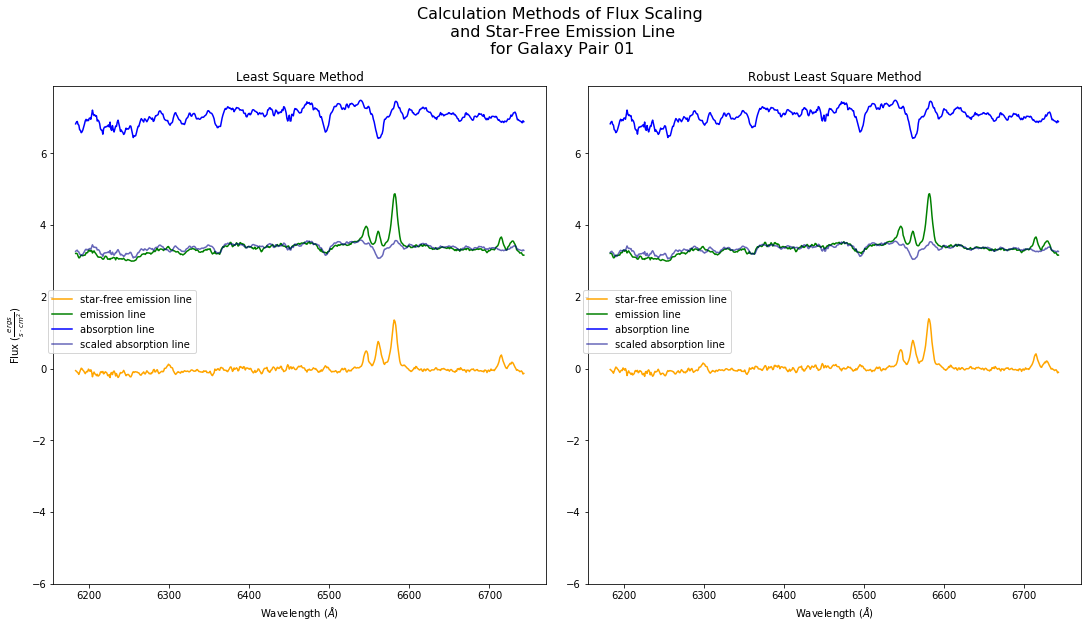

saved ./galaxyPairPlots/intensityScaling/intensityScaling02.png


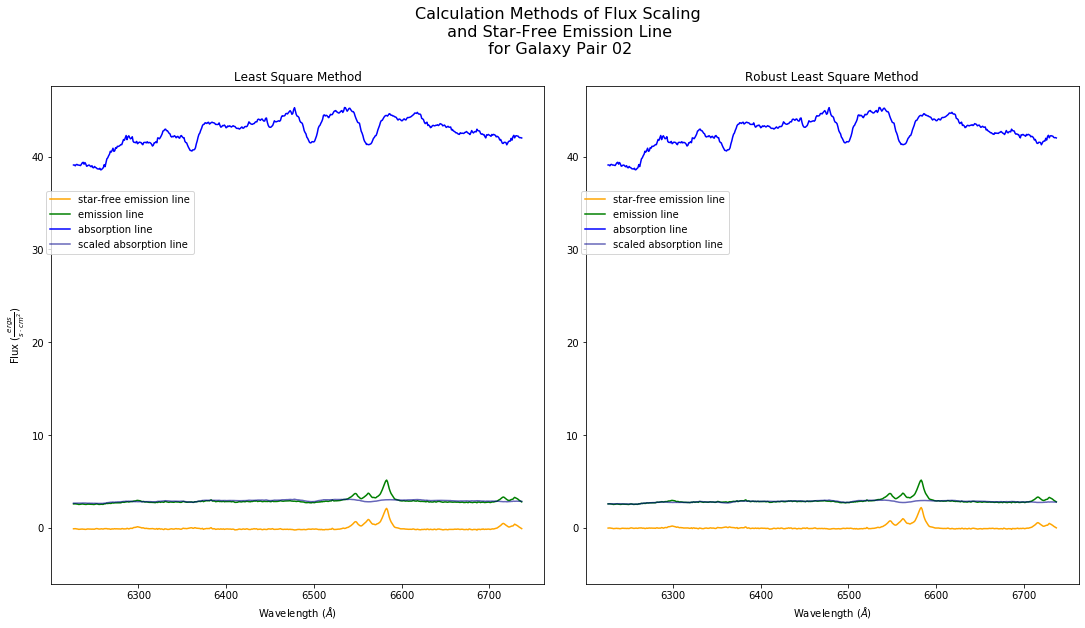

saved ./galaxyPairPlots/intensityScaling/intensityScaling03.png


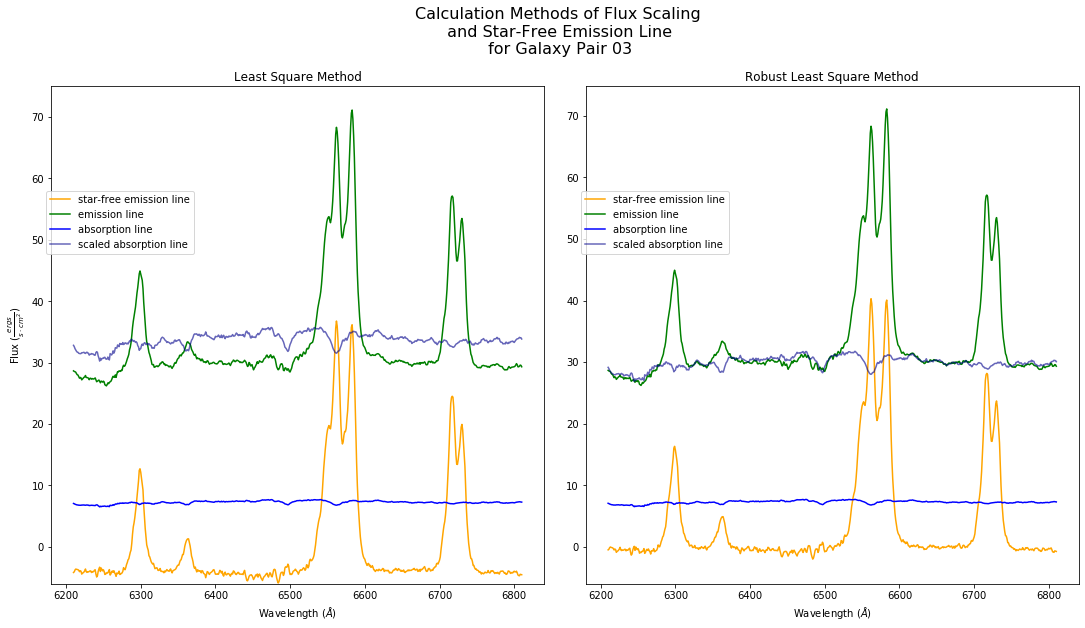

saved ./galaxyPairPlots/intensityScaling/intensityScaling04.png


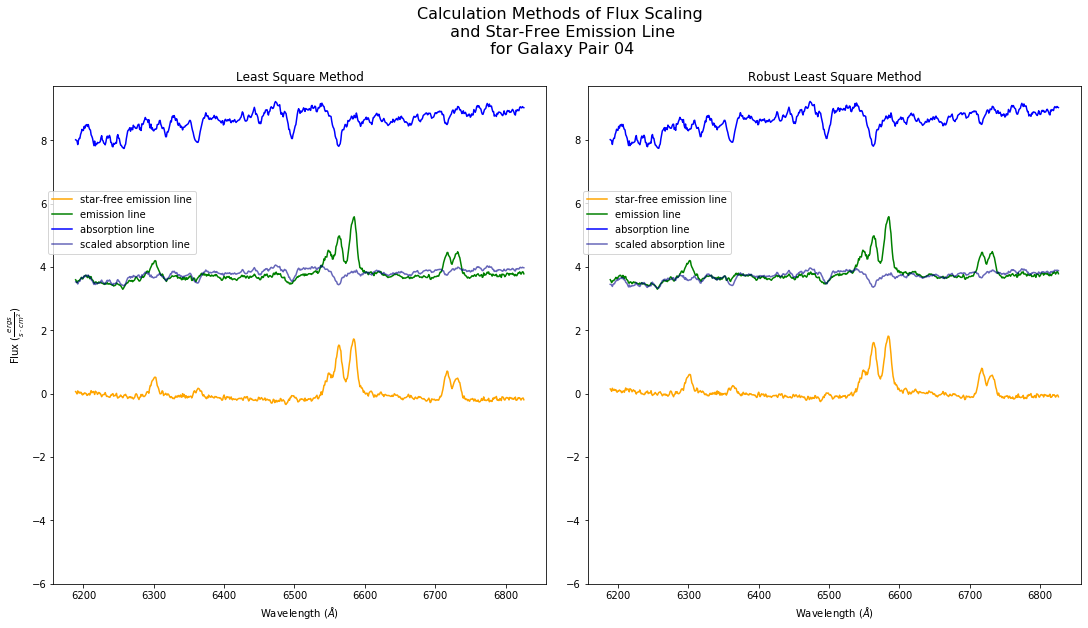

saved ./galaxyPairPlots/intensityScaling/intensityScaling05.png


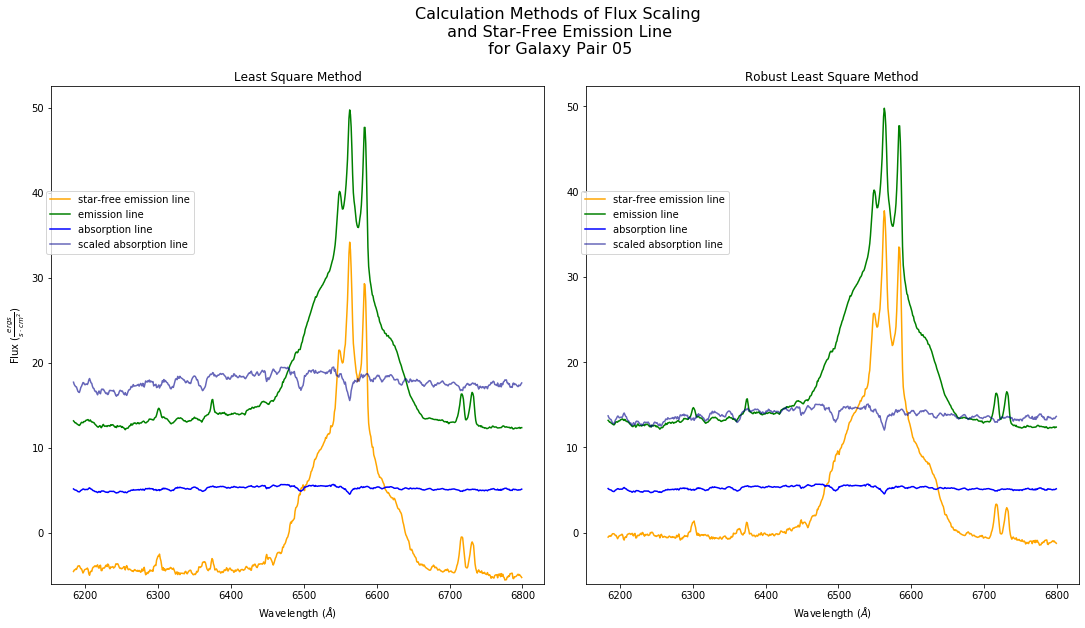

saved ./galaxyPairPlots/intensityScaling/intensityScaling06.png


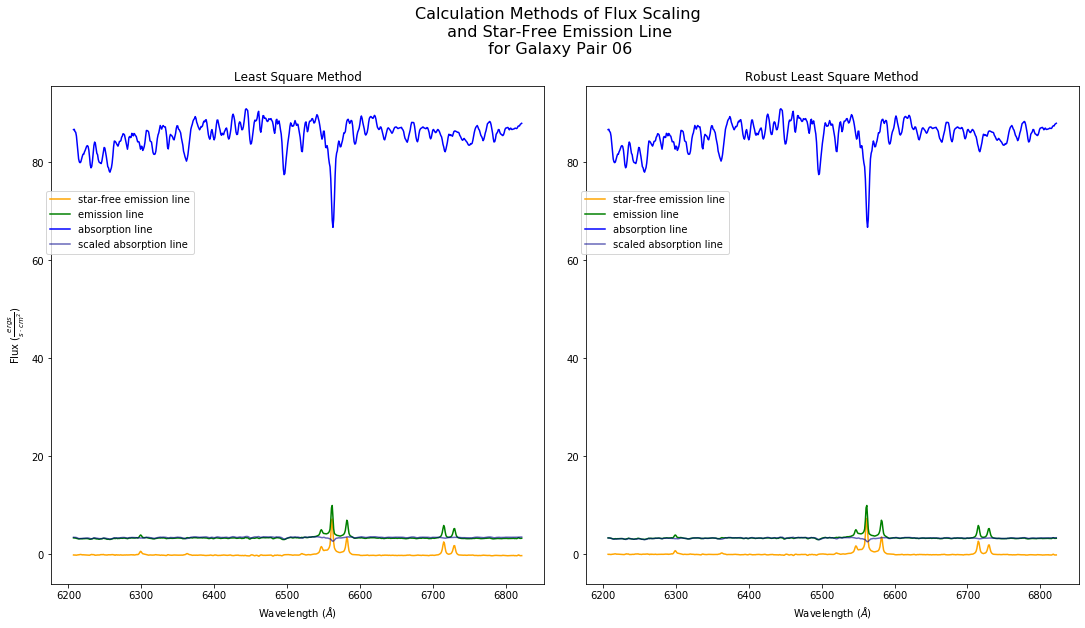

saved ./galaxyPairPlots/intensityScaling/intensityScaling07.png


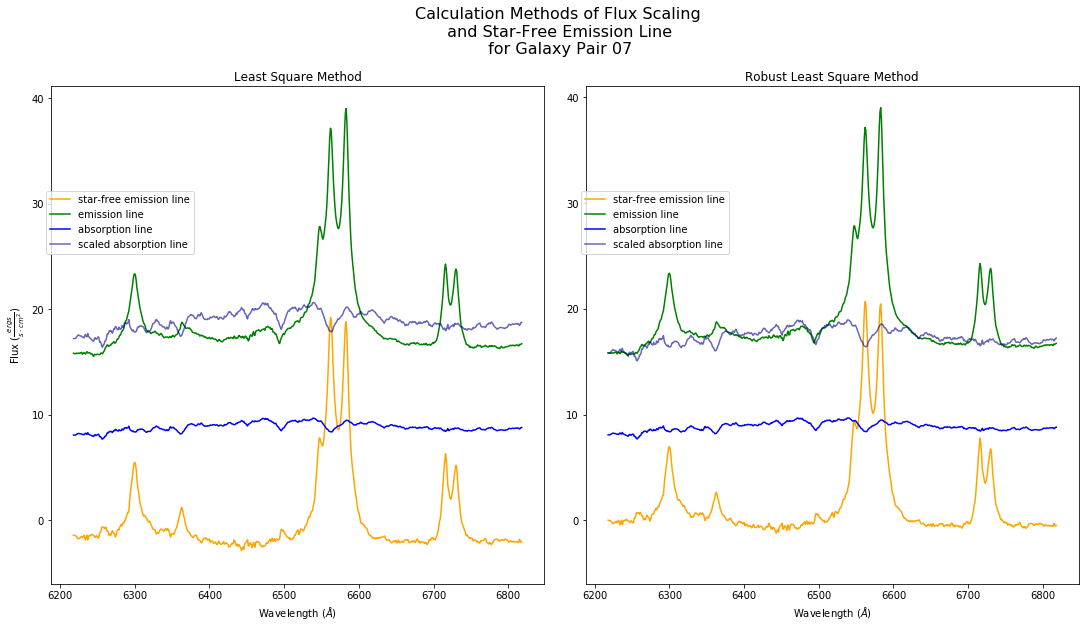

saved ./galaxyPairPlots/intensityScaling/intensityScaling08.png


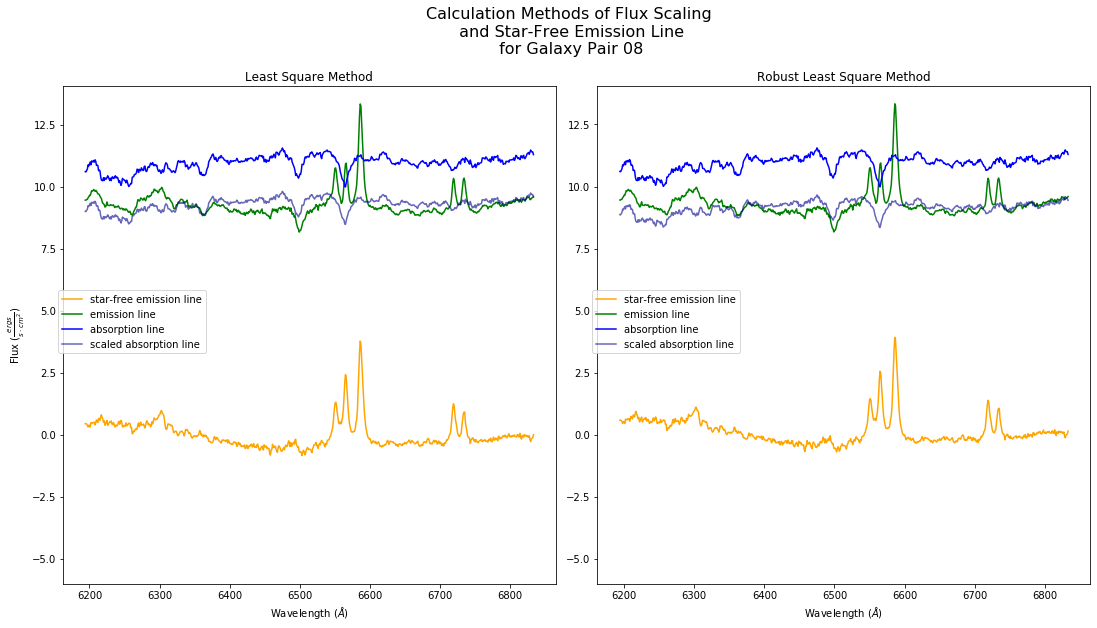

saved ./galaxyPairPlots/intensityScaling/intensityScaling09.png


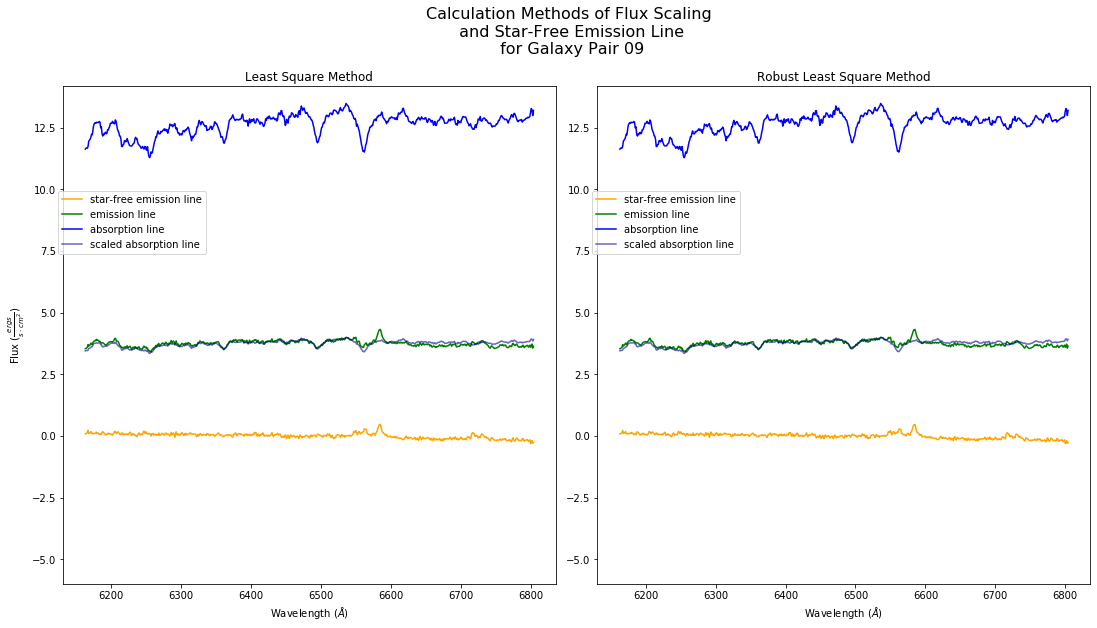

saved ./galaxyPairPlots/intensityScaling/intensityScaling10.png


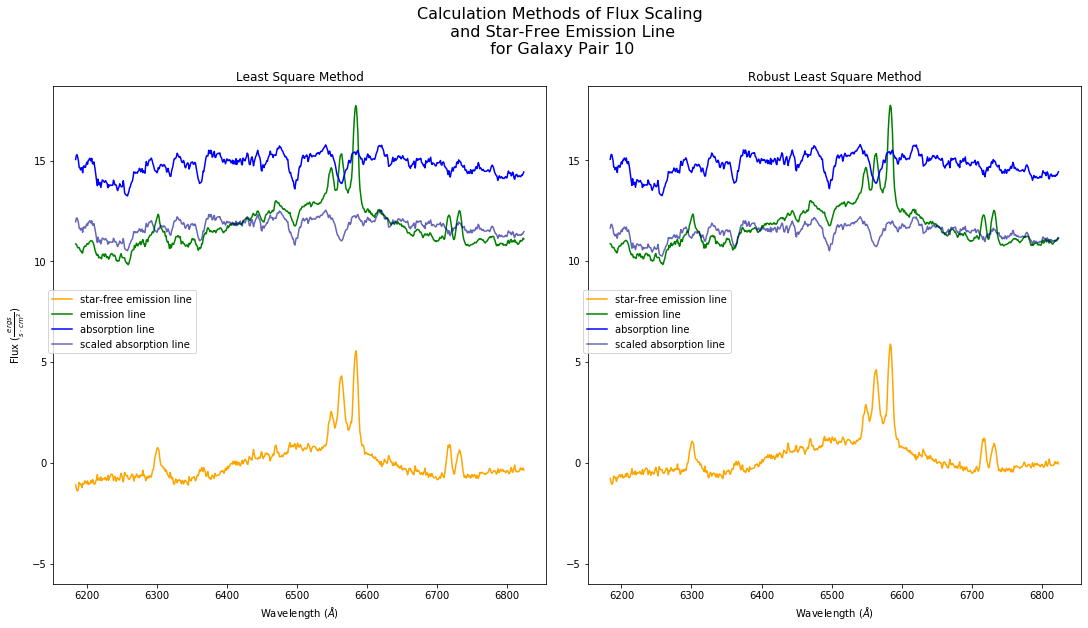

In [14]:
saveScaleSub = [scaleSub(pairNum=p,plot=True,savePlot=True) for p in fileIndex]

In [15]:
def tabler(save=False,colList=[]):
    tabDic = [scaleSub(ind,method='rls',table=True)[1] for ind in fileIndex]
    tab = pd.concat(tabDic)
    tab.reset_index(inplace=True)
    tab.drop(columns='index',inplace=True)
    cols = tab.columns.values.tolist()
    if colList:
        cols = [name for name in cols if name in colList]
        if save:
            directory = './galaxyPairTables/'
            fileName = str('galaxyPairTable('+str(len(cols))+'col)')
            createFolder(directory)
            tab.to_latex(directory+fileName+'.tex', columns = cols, longtable=True,
                         index = False,
                         caption = 'Flux Scaling')
            print('saved '+directory+fileName+'.tex')
            tab.to_html(directory+fileName+'.html', index = False)
            print('saved '+directory+fileName+'.tex')
            
    else:
        if save:
            directory = './galaxyPairTables/'
            fileName = 'galaxyPairTableFull'
            createFolder(directory)
            tab.to_latex(directory+fileName+'.tex', columns = cols, longtable=True,
                         index = False,
                         caption = 'Flux Scaling')
            print('saved '+directory+fileName+'.tex')
            tab.to_html(directory+fileName+'.html', index = False)
            print('saved '+directory+fileName+'.tex')
    return tab
    

In [16]:
saveTab = tabler(save=True)

saved ./galaxyPairTables/galaxyPairTableFull.tex
saved ./galaxyPairTables/galaxyPairTableFull.tex


#### Step Two

In [17]:
def iso(pairNum=0, wl=(6400,6700), lowFilt=False, verbose=False, plot=False, savePlot=False):
    minun = wl[0]
    plusle = wl[1]
    if pairNum <= 0 or pairNum > 10:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        pair = 1
        pairStr = str(0)+str(pair)
    elif pairNum != 10:
        pair = pairNum
        pairStr = str(0)+str(pair)
    elif pairNum == 10:
        pair = pairNum
        pairStr = str(pair)
    gal = scaleSub(pairNum
                   =pair)
    if lowFilt:
        gal[gal < 0] = 0
    portSpec = gal.query(' `Rest Wavelength` >= @minun ')
    portSpec = portSpec.query(' `Rest Wavelength` <= @plusle ')
    if verbose:
        print("galaxy pair "+pairStr)
        print('wavelength range: ',wl)
        if lowFilt:
            print('(setting values below zero to zero)')
        print('star-free emission line average: ',portSpec['Flux'].mean(),
              ' angstroms (std: ',portSpec['Flux'].std(),')')
        print('star-free emission line median: ',portSpec['Flux'].median(),
              ' angstroms')
    if plot:
        ax = portSpec.plot(x='Rest Wavelength',y='Flux',color='orange',
                      label='Star-Free Emission-Line Spectrum',figsize=(10,10))
        plt.axvline(x=6548,label=r'[$N_{II}$] (6548 $\AA$)',
                    linestyle='dotted',color='black')
        plt.axvline(x=6563,label=r'H$\alpha$ (6563 $\AA$)',
                    linestyle='dashed',color='black')
        plt.axvline(x=6583,label=r'[$N_{II}$] (6583 $\AA$)',
                    linestyle='dotted',color='black')
        ax.set(xlabel=r'Wavelength ($\AA$)',
               ylabel=r'Flux ($\frac{ergs}{s \cdot cm^{2}}$)')
        plt.legend()
        plt.title('Isolated Star-Free Emission-Line\n Spectrum of Galaxy Pair '+pairStr)
        if savePlot:
            directory = './galaxyPairPlots/isolatedSpectra/'
            createFolder(directory)
            mpl.pyplot.savefig(directory+'isolatedSpectrum'+pairStr+plotExt,bbox_inches='tight')
            print('saved '+directory+'isolatedSpectrum'+pairStr+plotExt)
        plt.show()
    return portSpec
            

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum01.png


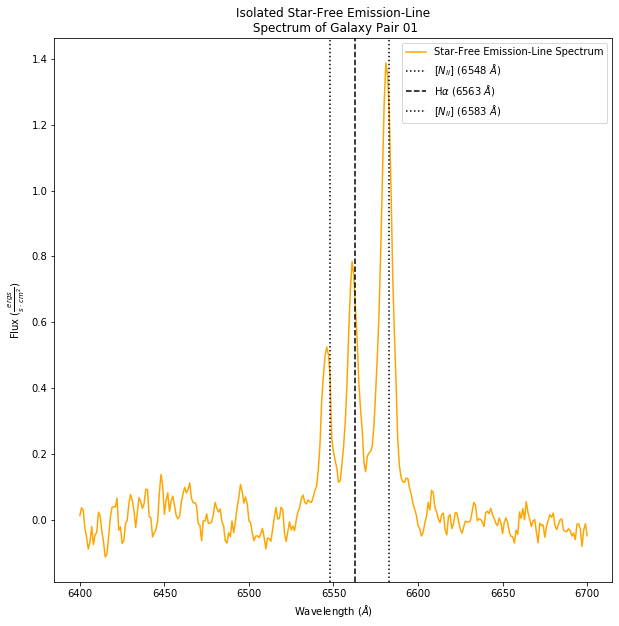

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum02.png


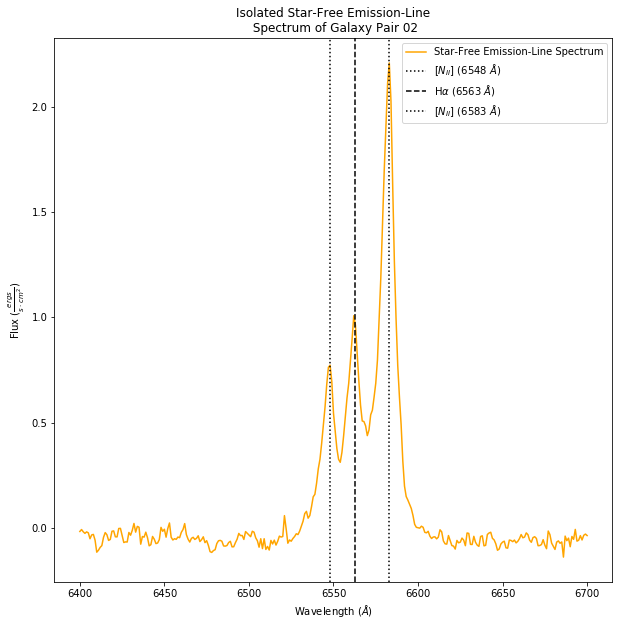

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum03.png


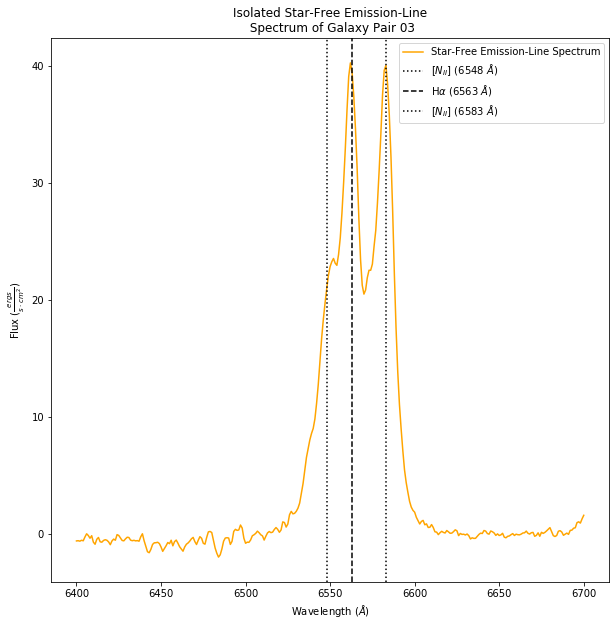

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum04.png


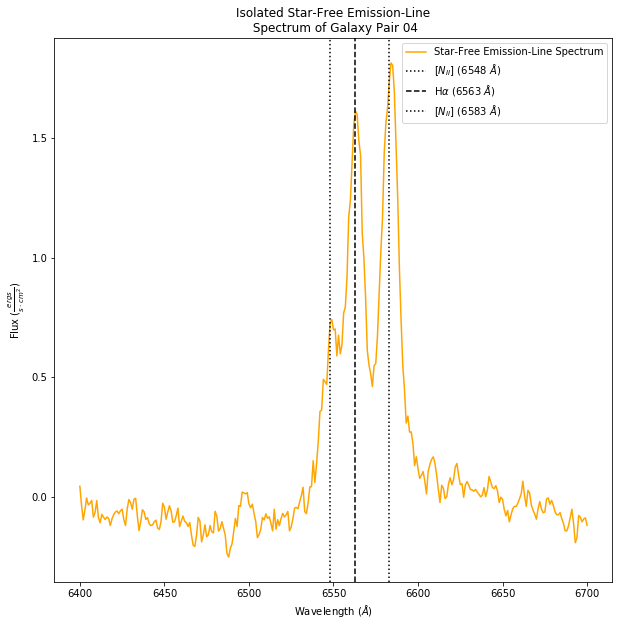

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum05.png


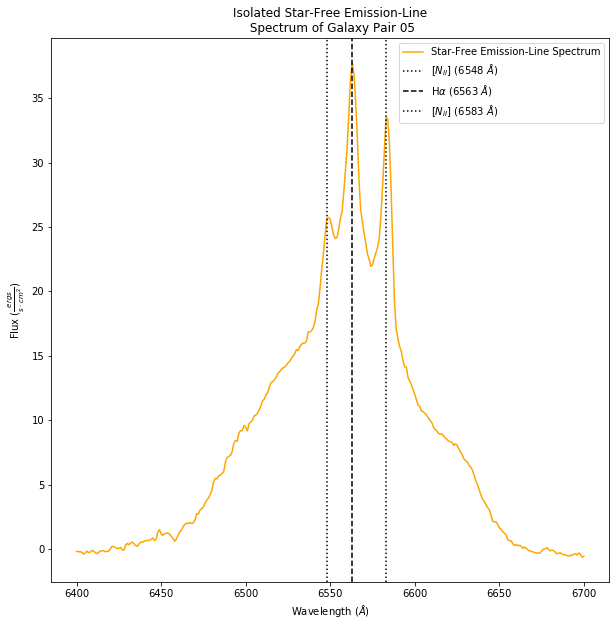

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum06.png


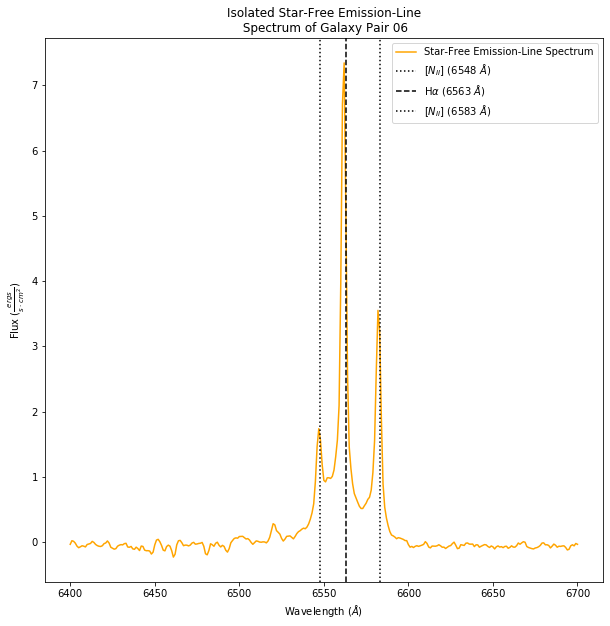

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum07.png


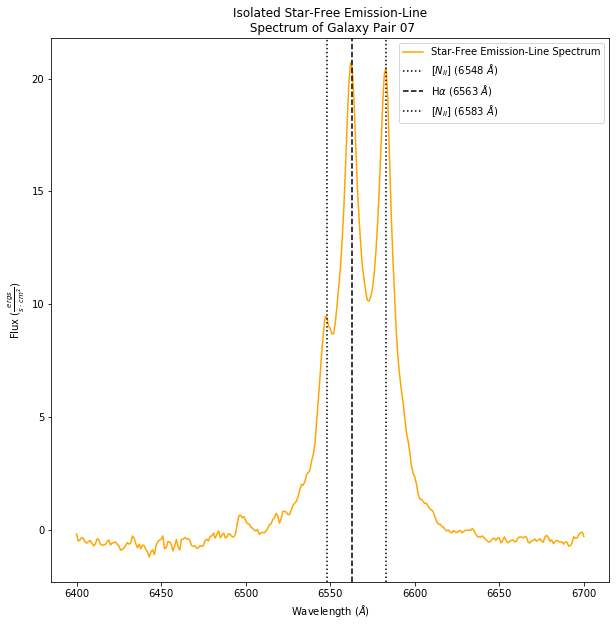

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum08.png


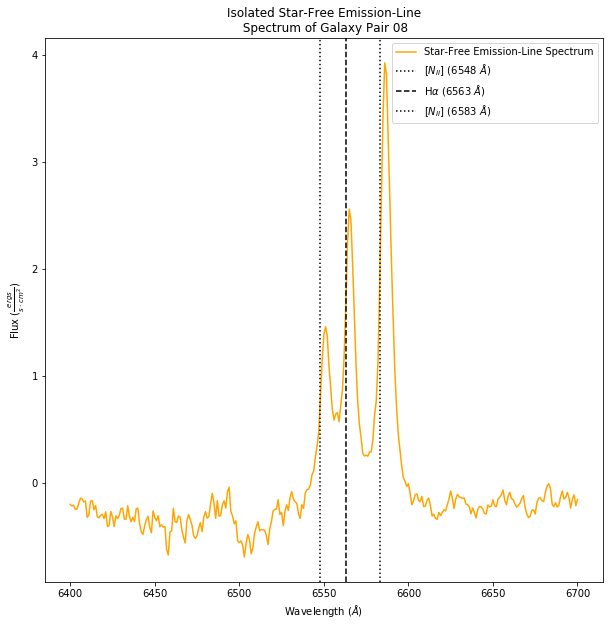

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum09.png


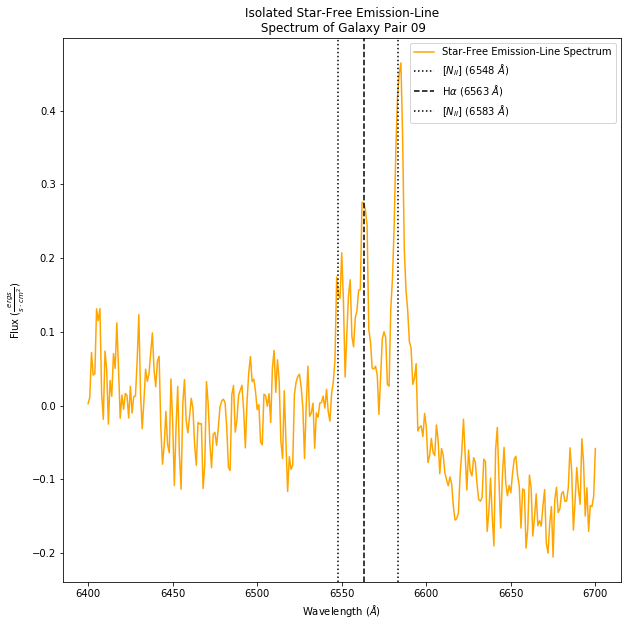

saved ./galaxyPairPlots/isolatedSpectra/isolatedSpectrum10.png


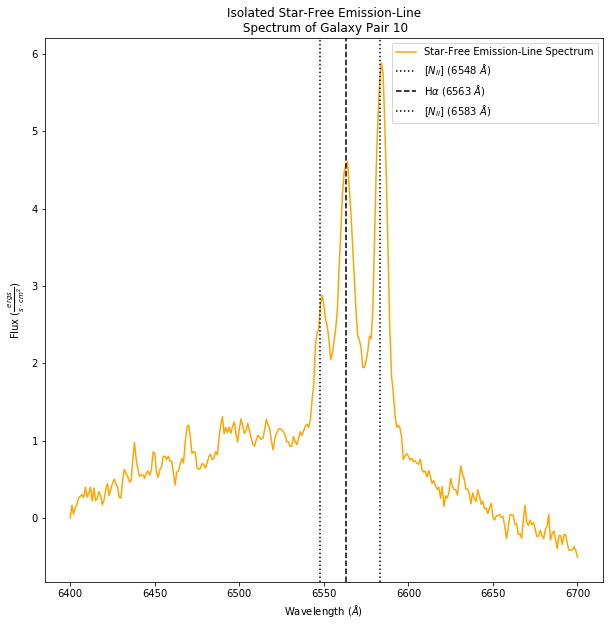

In [18]:
saveIso = [iso(pairNum=p,plot=True,savePlot=True) for p in fileIndex]

In [19]:
def decomp(pairNum=0, wl=(6400,6700), alpha = (0.5,0.5), defAlpha=True,
           twoPhase=True, snr= 5., verbose=False, plot=False, savePlot=False):
    
    minun = wl[0]
    plusle = wl[1]
    numPoints = round(abs(plusle-minun))
    waveRange = np.linspace(minun,plusle,numPoints+1)
    defaultAlpha = [(1e-5, 0.1), (1e-3,0.6), (1e-5, 0.8), (1e-5,0.1), (1e-5, 0.8),
                   (1e-5, 0.6), (1e-5, 0.6), (1e-5, 0.8), (1e-5, 0.1), (1e-5, 0.8)]
    ## pair 7 possibly (1e-5,0.6), but causes two broad velocity components
    ## pair 6 
    
    
    if pairNum <= 0 or pairNum > 10:
        print('add an argument between 1 and 10 for the spectrum pair, ya dingus')
        print('defaulting to pair 01')
        pair = 1
        pairStr = str(0)+str(pair)
    elif pairNum != 10:
        pair = pairNum
        pairStr = str(0)+str(pair)
    elif pairNum == 10:
        pair = pairNum
        pairStr = str(pair)
    
    spec = iso(pairNum=pair,wl=wl)
    
    if defAlpha and alpha == (0.5,0.5):
        alpha1 = defaultAlpha[pair-1][0]
        if twoPhase:
            alpha2 = defaultAlpha[pair-1][1]
    elif defAlpha and alpha != (0.5,0.5):
        alpha1 = alpha[0]
        if twoPhase:
            alpha2 = alpha[1]
    elif not defAlpha and alpha == (0.5,0.5):
        alpha1 = alpha[0]
        if twoPhase:
            alpha2 = alpha[1]
    elif not defAlpha and alpha != (0.5,0.5):
        alpha1 = alpha[0]
        if twoPhase:
            alpha2 = alpha[1]
    snr_thresh = snr
    
    directory = str('./linePickles/')
    createFolder(directory)
    
    fileDirec = str(directory+'line'+pairStr+'.pickle')
    decompDirec = str(directory+'lineDecomp'+pairStr+'.pickle')
    NCOMPS = 4
    rms = float(spec['Flux'].std())
    numChan = int(spec.shape[0])
    
    data = {}
    chan = np.arange(numChan)
    errors = np.ones(numChan) * rms
    spectrum = spec['Flux'].to_numpy()

    data['data_list'] = data.get('data_list', []) + [spectrum]
    data['x_values'] = data.get('x_values', []) + [chan]
    data['errors'] = data.get('errors', []) + [errors]
    
    with open(fileDirec, "wb") as f:
        pickle.dump(data, f)
        f.close()
    
    g = gp.gp.GaussianDecomposer()
    if twoPhase:
        g.set('phase', 'two')
        g.set('SNR_thresh', [snr_thresh, snr_thresh])
        g.set('alpha1', alpha1)
        g.set('alpha2', alpha2)
    elif not twoPhase:
        g.set('phase', 'one')
        g.set('SNR_thresh', [snr_thresh, snr_thresh])
        g.set('alpha1', alpha1)
    
    data_decomp = g.batch_decomposition(fileDirec)
    with open(decompDirec, 'wb') as f:
        pickle.dump(data_decomp, f)
        f.close()
    
    with open(fileDirec,'rb') as f:
        data = pickle.load(f)
        f.close()
    spectrum = unravel(data['data_list'])
    chan = unravel(data['x_values'])
    errors = unravel(data['errors'])

    with open(decompDirec,'rb') as f:
        data_decomp = pickle.load(f)
    means_fit = unravel(data_decomp['means_fit'])
    amps_fit = unravel(data_decomp['amplitudes_fit'])
    fwhms_fit = unravel(data_decomp['fwhms_fit'])
    
    gaussParams = np.array([(amps_fit[fit], fwhms_fit[fit], means_fit[fit])
                           for fit in range(len(means_fit))])
    gaussFits = np.array([gaussian(amps_fit[fit], fwhms_fit[fit], means_fit[fit])(chan)
                          for fit in range(len(means_fit))])
    model = gaussFits.sum(axis=0)
    modelDiff = model - spectrum
    
    if verbose:
        print("galaxy pair "+pairStr)
        print('wavelength range: ',wl)
        if twoPhase:
            print('using two phase decomposition')
        elif not twoPhase:
            print('using one phase decomposition')
        if defAlpha and alpha == (0.5,0.5):
            if twoPhase:
                print('using default alpha values: alpha1='+str(alpha1)+', alpha2='+str(alpha2))
            elif not twoPhase:
                print('using default alpha value: alpha1='+str(alpha1))
        else:
            if twoPhase:
                print('using provided alpha values: alpha1='+str(alpha1)+', alpha2='+str(alpha2))
            elif not twoPhase:
                print('using provided alpha value: alpha1='+str(alpha1))
        print('Fitted to '+str(len(means_fit))+' Gaussians')
        
    if plot:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7.5))
        fig.tight_layout(h_pad=-1.0)
        if twoPhase:
            tit = str('Gaussian Decomposition of Galaxy Pair '+pairStr+
                      '\n (alpha1='+str("{:.1E}".format(alpha1))+
                      ', alpha2='+str(alpha2)+
                      ', snr='+str(snr_thresh)+')')
        elif not twoPhase:
            tit = str('Gaussian Decomposition of Galaxy Pair '+pairStr+
                      '\n (alpha1='+str("{:.1E}".format(alpha1))+
                      ', snr='+str(snr_thresh)+')')
        fig.suptitle(tit,y=1.12,fontsize=16)
        ax1.set_title('Fitted Gaussian Components')
        ax1.set(xlabel = r'Wavelength ($\AA$)', 
                ylabel=r'Flux ($\frac{ergs}{s \cdot cm^{2}}$)')
        ax1.plot(waveRange, spectrum, label='Star-Free Emission Line',
                 color='black', linewidth=1, alpha=0.5, marker='.', linestyle='-')
        for fit in range(len(means_fit)):
            rand.seed(fit)
            r = (rand.random()**(rand.random()) %1)
            g = (rand.random()**(rand.random()+2*rand.random()) %1)
            b = np.linspace(rand.random(),1,len(means_fit))
            col = (r, g, b[fit])
            compName = str('Gaussiant '+str(fit+1))
            ax1.plot(waveRange, gaussFits[fit], label=compName,
                    color = col)
        if modelDiff.min() <= spectrum.min():
            ax1.set_ylim([1.1*modelDiff.min(),1.1*spectrum.max()])
        if modelDiff.min() > spectrum.min():
            ax1.set_ylim([1.1*spectrum.min(),1.1*spectrum.max()])
        ax1.legend()
        
        ax2.set_title('Total Fitted Gaussian')
        ax2.set(xlabel=r'Wavelength ($\AA$)')
                #,ylabel=r'Flux ($\frac{ergs}{s \cdot cm^{2}}$)')
        ax2.plot(waveRange, spectrum, label='Star-Free Emission Line',
                 color='black', linewidth=0.5, alpha=0.6, marker='.', ms=2, linestyle='-')
        ax2.plot(waveRange, model, label='Sum of Fitted Gaussians', 
                 color='blue', linewidth=2)
        ax2.plot(waveRange, modelDiff, label='Difference From Data',
                color='green',linewidth=2)
        if modelDiff.min() <= spectrum.min():
            ax2.set_ylim([1.1*modelDiff.min(),1.1*spectrum.max()])
        if modelDiff.min() > spectrum.min():
            ax2.set_ylim([1.1*spectrum.min(),1.1*spectrum.max()])
        ax2.legend()
        if savePlot:
            directory = './galaxyPairPlots/gaussDecomp/'
            if defAlpha and alpha == (0.5,0.5):
                directory += 'defaultAlpha/'
            createFolder(directory)
            uVal = str('(a1='+str("{:.0E}".format(alpha1)).replace('.', '')+
                       '_a2='+str("{:.0E}".format(alpha2)).replace('.', '')+
                       '_snr='+str("{:.0E}".format(snr_thresh)).replace('.', '')+')')
            fig.savefig(directory+'decompSpec'+pairStr+uVal+plotExt,bbox_inches='tight')
            print('saved '+directory+'decompSpec'+pairStr+uVal+plotExt)
        
        plt.show()
    return gaussParams, gaussFits
    

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec01(a1=1E-05_a2=1E-01_snr=5E+00).png


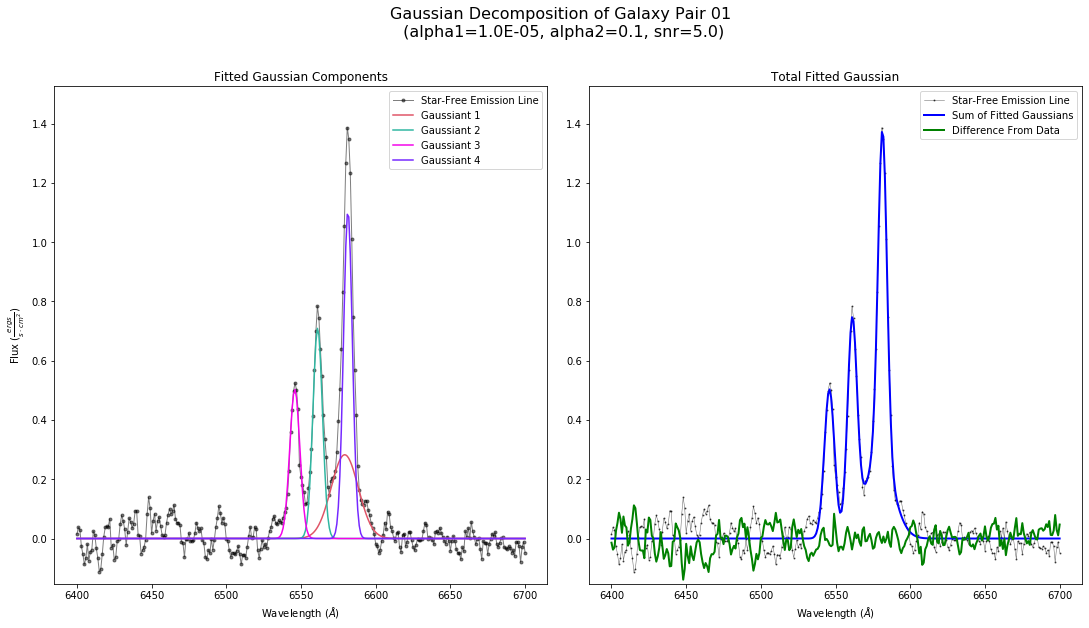

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec02(a1=1E-03_a2=6E-01_snr=5E+00).png


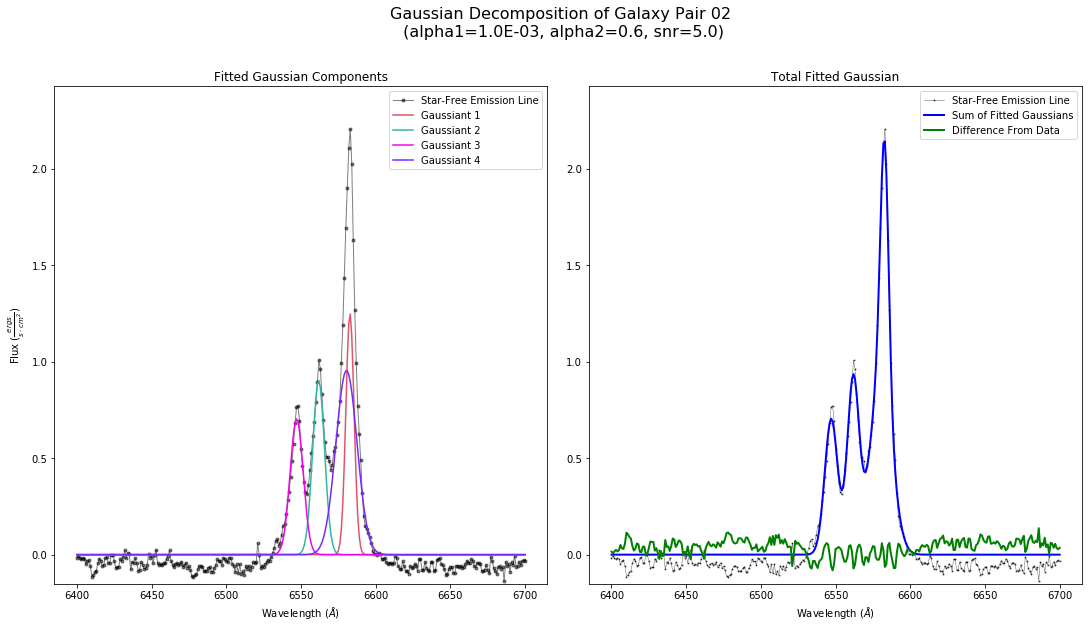

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec03(a1=1E-05_a2=8E-01_snr=5E+00).png


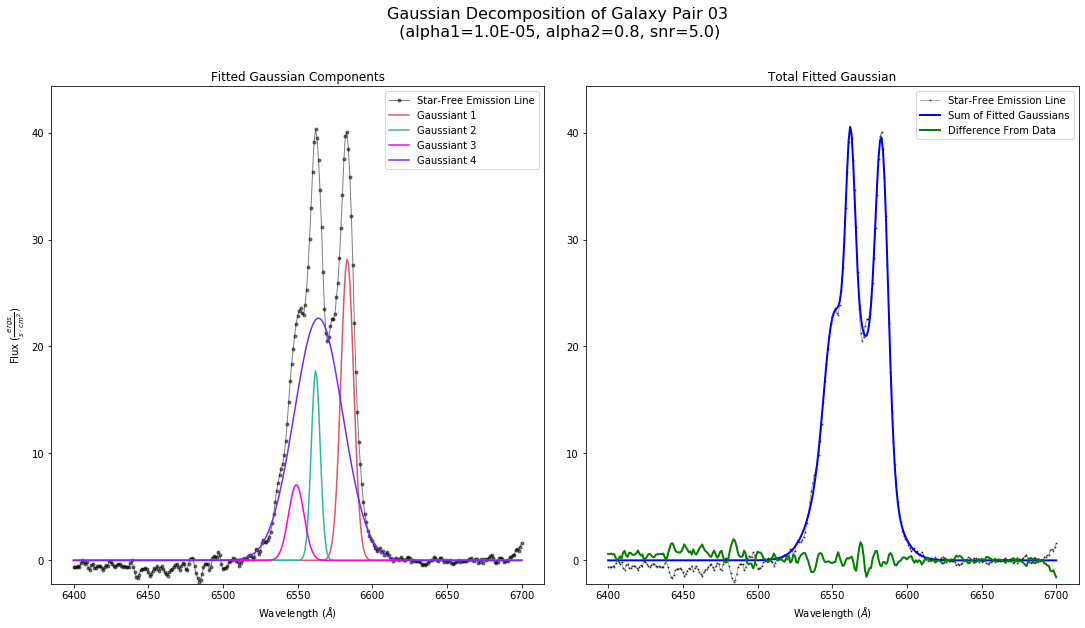

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec04(a1=1E-05_a2=1E-01_snr=5E+00).png


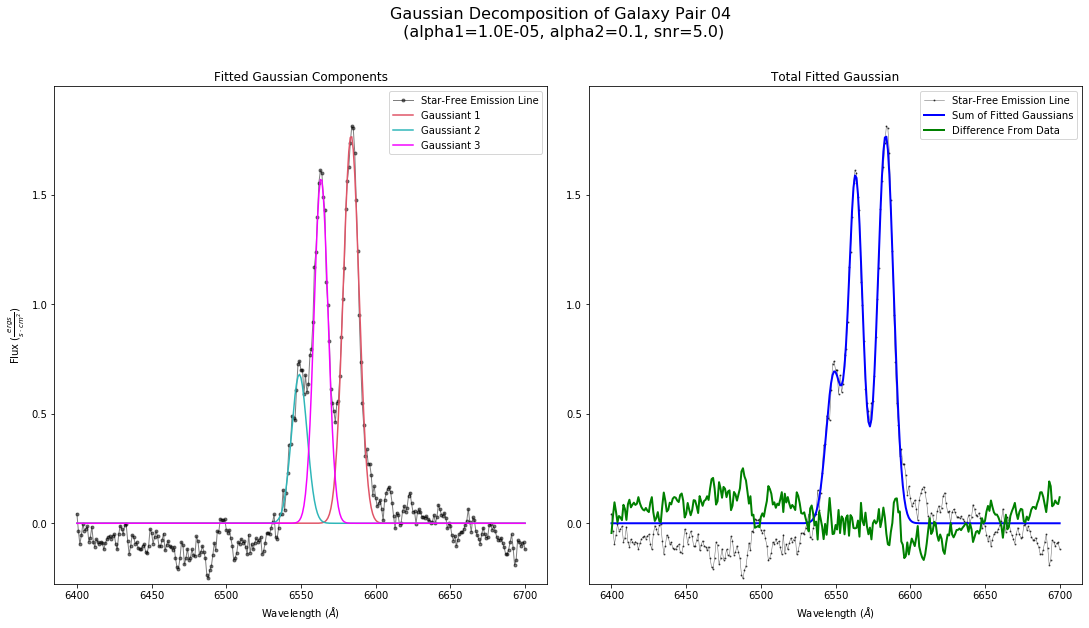

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec05(a1=1E-05_a2=8E-01_snr=5E+00).png


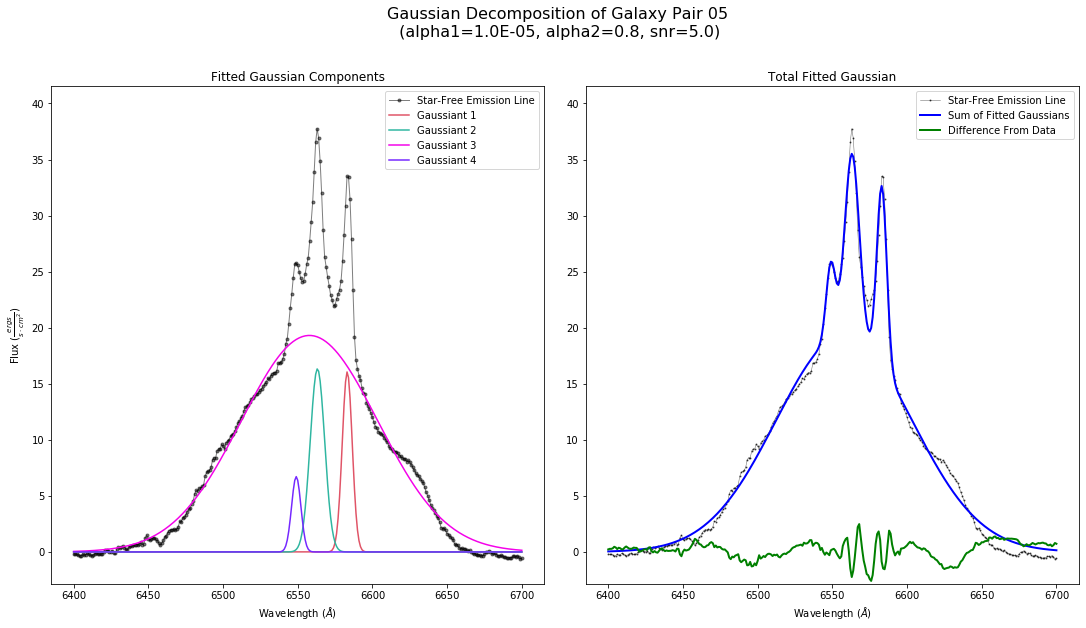

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec06(a1=1E-05_a2=6E-01_snr=5E+00).png


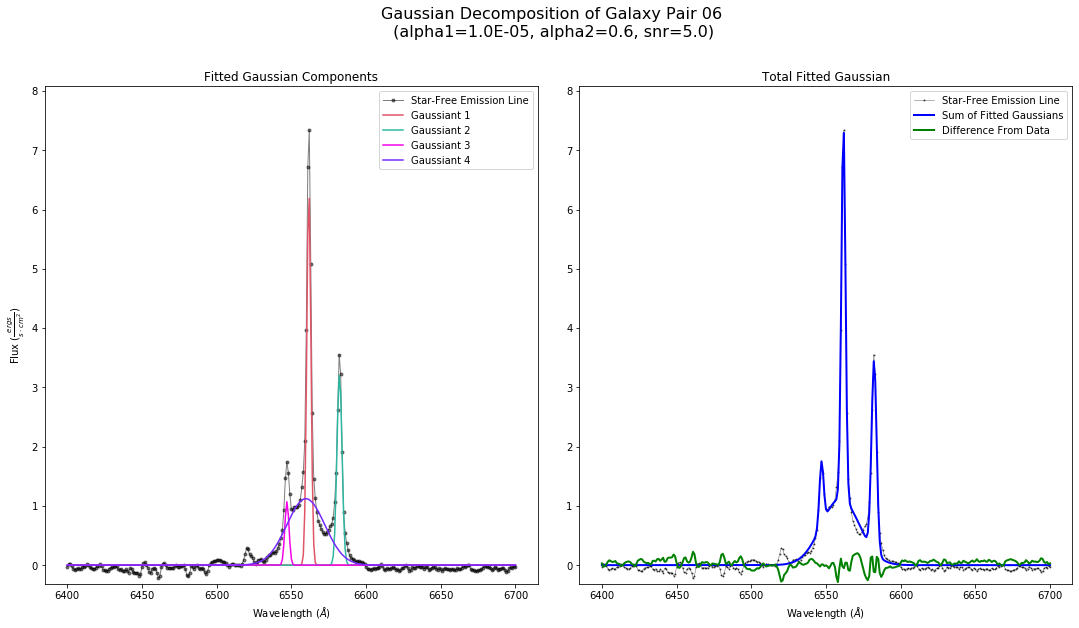

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec07(a1=1E-05_a2=6E-01_snr=5E+00).png


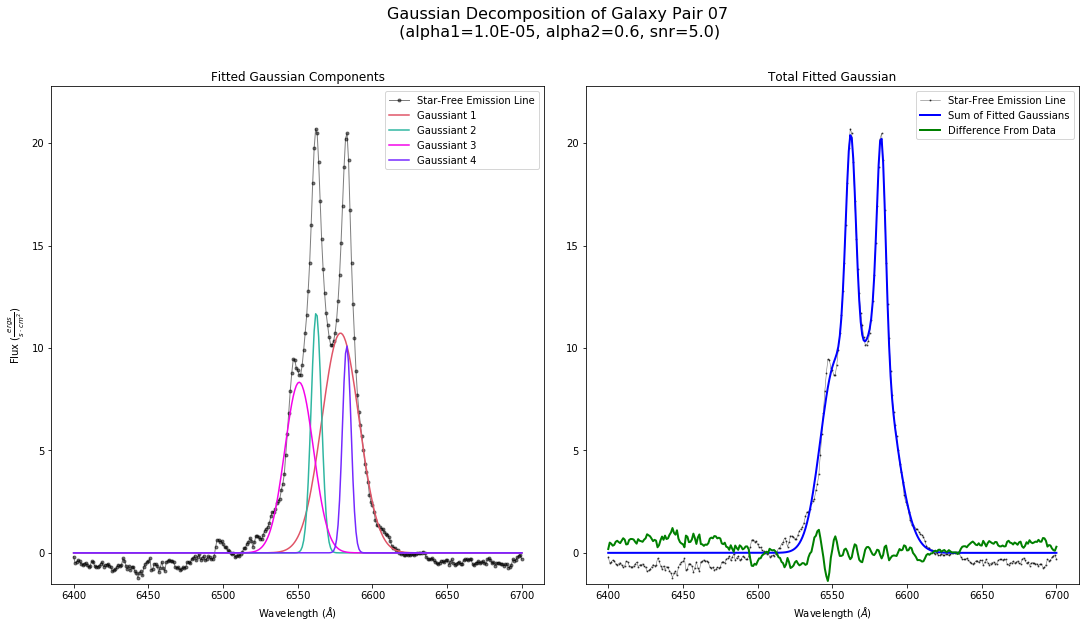

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec08(a1=1E-05_a2=8E-01_snr=5E+00).png


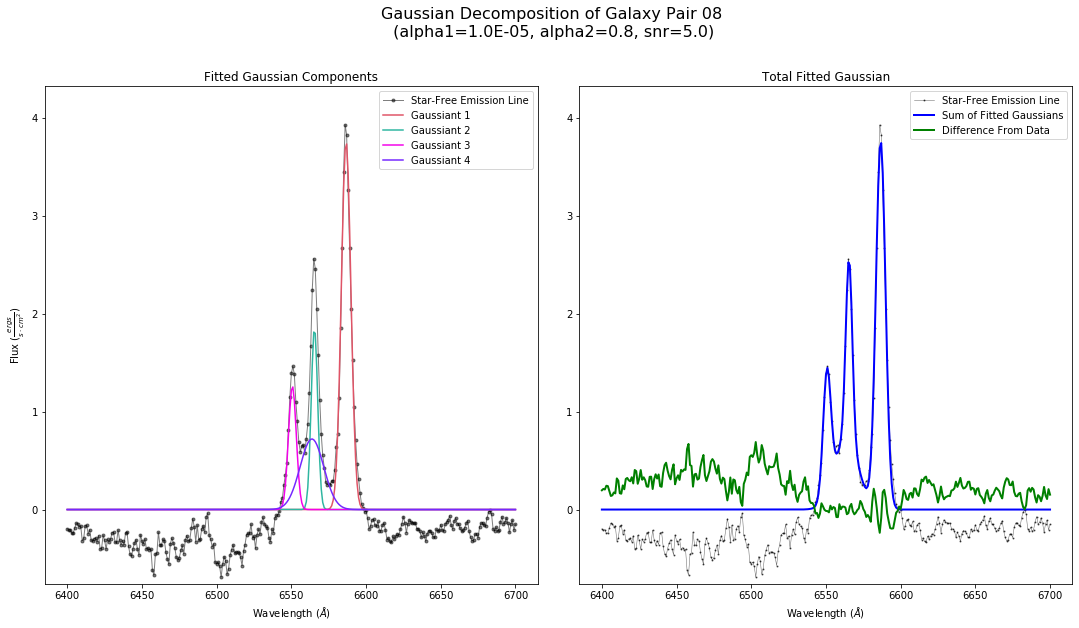

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec09(a1=1E-05_a2=1E-01_snr=5E+00).png


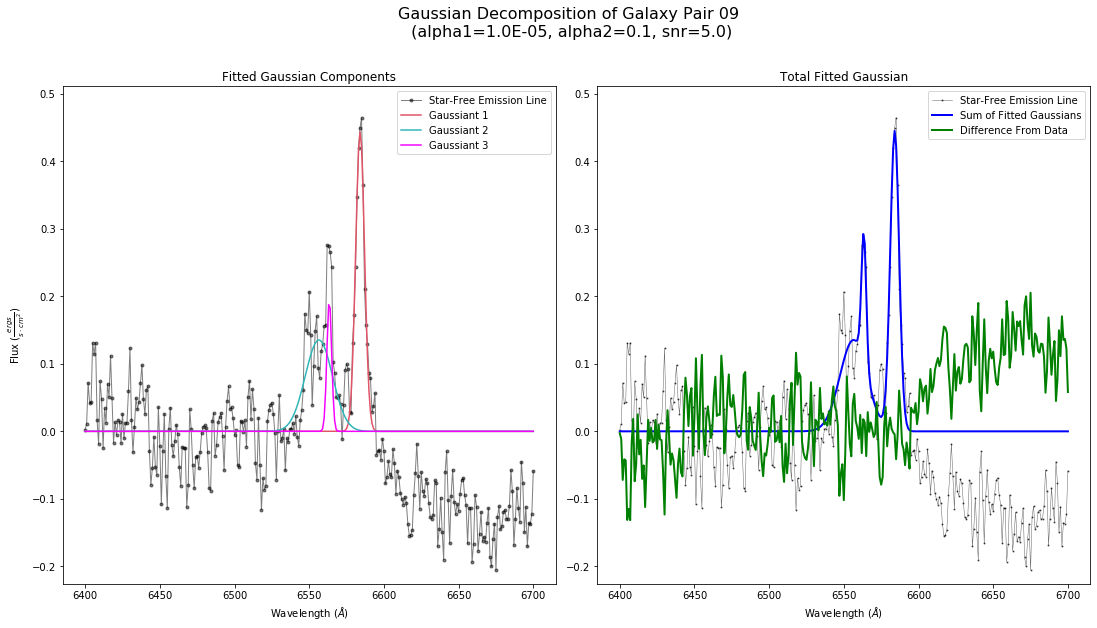

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]


SUCCESS
100 finished.%
saved ./galaxyPairPlots/gaussDecomp/defaultAlpha/decompSpec10(a1=1E-05_a2=8E-01_snr=5E+00).png


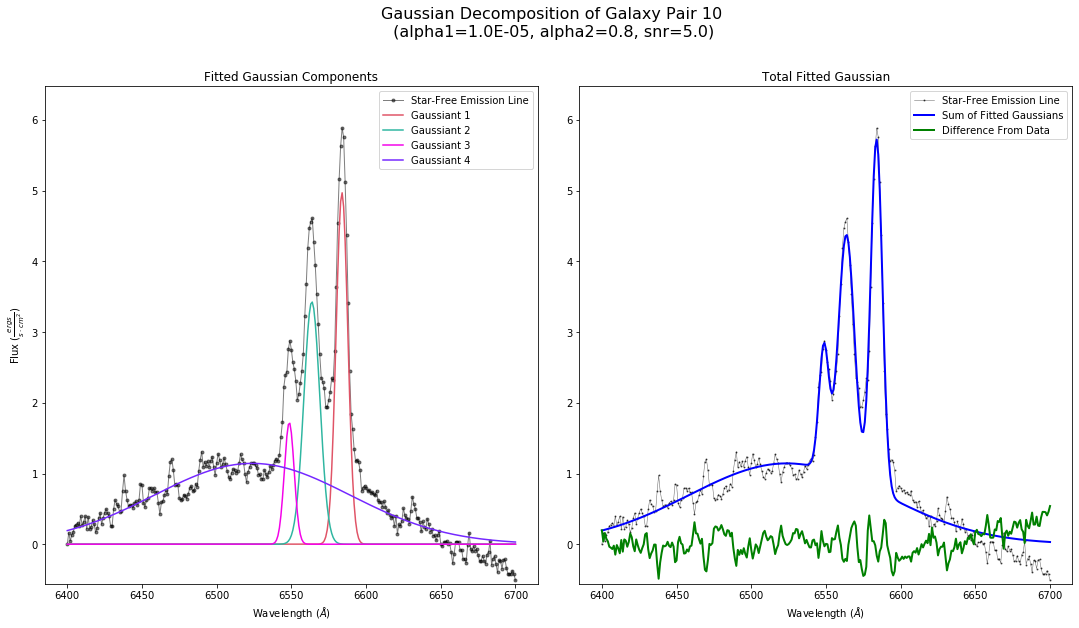

using 6 out of 8 cpus
   ---->   0


0.00it [00:00, ?it/s]
0it [00:00, ?it/s]

SUCCESS
100 finished.%


In [20]:
saveGauss = [decomp(pairNum=p,verbose=False,plot=True, savePlot=True) for p in fileIndex]
gauss = decomp(pairNum=5,verbose=False,plot=False,savePlot=False)

In [21]:
testG = gaussian(gauss[0][2,0],gauss[0][2,1],gauss[0][2,2]+6400)#(np.linspace(6400,6700,6700-6400+1))
quad(testG,6400,6700)

(2204.716459621881, 7.065941106569036e-11)

#### Step Three

In [22]:
def getFlux(gaussParams, wl):
    minun=wl[0]
    plusle = wl[1]
    amp = gaussParams[0]
    fwhm = gaussParams[1]
    mean = gaussParams[2] + minun
    gaussFunc = gaussian(amp, fwhm, mean)
    flux = quad(gaussFunc,minun,plusle)
    return flux

def getLum(flux, dist):
    if dist in distMpc:
        dist = dist * 1000 * u.pc
        dist = dist.to_value(u.cm)
    luminosity = (4 * np.pi * dist**2) * flux *u.
    return luminosity



SyntaxError: invalid syntax (<ipython-input-22-9d8d934af0d4>, line 15)